# This file contains the preprocessing for price data and company factors data, and the y-label data from 2000. The sentiment data starting from 2020 is not taken into consideration here since I want the features to be consistent. (This layout for maximizing training size would generate the best result)

## Setting up the environment and getting all the data

In [ ]:
! pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=99f3d30fbdefddcfcbd45dc870942d6d4eaafd33ea6316968ae0d6468310be1c
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
! pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import h5py
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import ta
from sklearn.preprocessing import MinMaxScaler


In [ ]:
! pip install ta

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
DATA_NOT_SCRAPED = False #indicate whether we have to scrape data again. False since I've scraped it already, so we can read it directly.
PATH_sentiment = '/content/gdrive/MyDrive/lazard/consumer_comp_news_sentiment.csv'
PATH_comp_factors = '/content/gdrive/MyDrive/lazard/x_df_comp_factors.h5'
PATH_mapping = '/content/gdrive/MyDrive/lazard/rp_full_ticker_mapping.xlsx'
PATH_y = '/content/gdrive/MyDrive/lazard/y_series_return.h5'
PATH_price = '/content/gdrive/MyDrive/lazard/price_data_2000.csv' # self-scraped data
LOOKBACK = 60
THRESHOLD = 2

In [ ]:
y_df = pd.read_hdf(PATH_y) # 2000-2023, monthly
y_df.sort_values(by = ['security','date'], inplace = True)
y_df = y_df.dropna(subset = ['MONTHLY_RETURN', "MONTHLY_RETURN_F1"])

cf = pd.read_hdf(PATH_comp_factors) # 2000-2023, monthly, optional
cf.sort_values(by = ['security','date'], inplace = True)

price_data = pd.read_csv(PATH_price) # 2000-2023, daily
unnamed_cols = [col for col in price_data.columns if 'Unnamed' in col]
# If there are unnamed columns, drop them
if unnamed_cols:
  price_data = price_data.drop(unnamed_cols, axis=1)
price_data['date'] = pd.to_datetime(price_data['date'])


In [ ]:
mapping_data= pd.read_excel(PATH_mapping)
ID2security = {}
security2ticker = {}
ID2ticker = {}

for i, row in mapping_data.iterrows():
  ID2security[row['RP_ENTITY_ID']] = row['security']
  security2ticker[row['security']] = row['ticker']
  ID2ticker[row['RP_ENTITY_ID']] = row['ticker']


picture，technical indicators, data put into different dfs.

In [ ]:
y_df.columns

Index(['security', 'date', 'MONTHLY_RETURN', 'MONTHLY_RETURN_F1'], dtype='object')

In [ ]:
price_data # the price data from 2000 to 2023 to match the y_label

date        Open        High         Low       Close   Adj Close  \
0      2000-02-29    3.300000    3.448438    3.293750    3.443750    3.443750   
1      2000-03-01    3.381250    3.425000    3.250000    3.293750    3.293750   
2      2000-03-02    3.246875    3.250000    3.109375    3.128125    3.128125   
3      2000-03-03    3.162500    3.237500    3.103125    3.125000    3.125000   
4      2000-03-06    3.143750    3.362500    3.140625    3.196875    3.196875   
...           ...         ...         ...         ...         ...         ...   
133439 2023-09-22  124.650002  125.830002  124.099998  125.000000  125.000000   
133440 2023-09-25  124.519997  125.400002  124.269997  124.970001  124.970001   
133441 2023-09-26  124.239998  124.739998  123.449997  124.010002  124.010002   
133442 2023-09-27  124.010002  124.410004  121.139999  121.980003  121.980003   
133443 2023-09-28  121.699997  124.220001  121.540001  124.080002  124.080002   

           Volume        security  
0       142970000  AMZN US Equity  
1       111534000  AMZN US Equity  
2       159602000  AMZN US Equity  
3       121190000  AMZN US Equity  
4       153316000  AMZN US Equity  
...           ...             ...  
133439    1534100   YUM US Equity  
133440    1048500   YUM US Equity  
133441    1500600   YUM US Equity  
133442    1922300   YUM US Equity  
133443    1722700   YUM US Equity  

[133444 rows x 8 columns]

# Preprocess Data

## preprocess labels: remove missing labels

In [ ]:
print(y_df.shape)
y_df.dropna(subset=['MONTHLY_RETURN', 'MONTHLY_RETURN_F1'], inplace=True)
print(y_df.shape)


(6388, 4)
(6388, 4)


## Useful Functions

In [ ]:
def technical_features_price(df):
  columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
  df = df.copy()
  df.sort_values(by=['security','date'], inplace = True)
  securities = list(df['security'].unique())
  sub_dfs = []
  for security in securities:
      df_security = df[df['security'] == security]
      df_security['daily_return'] = df_security['Close'] / df_security['Open'] - 1

      df_security['price_diff'] = df_security['Close'].diff(1)
      #df_security['vol_log'] = df_security['Volume'].apply(np.log)
      #df_security['vol_diff_1'] = df_security['Volume'].diff(1)
      #df_security['vol_diff_50'] = df_security['Volume'].diff(50)

      # Rate of change in volume
      df_security['roc_vol'] = ta.momentum.roc(df_security['Volume'])

      for period in [5, 10, 15]:# 20, 30]:
          # Moving average of Close
          df_security[f'ma{period}_close'] = df_security['Close'].rolling(window=period).mean()

          # Moving average of volume (log)
          #df_security[f'sma{period}_vollog'] = df_security['vol_log'].rolling(window=period).mean()

          # Closing price vs n-day EMA
          df_security[f'close_vs_ema{period}'] = df_security['Close'] / df_security['Close'].ewm(span=period).mean() - 1

          # Daily Volume vs. n-day SMA
          df_security[f'vol_vs_sma{period}'] = df_security['Volume'] / df_security['Volume'].rolling(window=period).mean() - 1

      # exponantial moving average for each column
      for col in columns:
        if col != 'Volume':
          df_security[f'EMA05_{col}'] = df_security[col].ewm(com=0.5).mean() # more weight to later data


      # Average True Range (14-day)
      #df_security['atr'] = ta.volatility.average_true_range(df_security['High'],df_security['Low'], df_security['Close'], window = 14)

      # High divided by Average True Range with window of 10
      df_security['high10atr'] = df_security['High'] / ta.volatility.average_true_range(df_security['High'], df_security['Low'], df_security['Close'], window =10)

      # Relative Strengh Index (RSI)
      df_security['RSI'] = ta.momentum.rsi(df_security['Close'], window = 14)

      # Money Flow Index (MFI)
      df_security['MFI'] = ta.volume.money_flow_index(df_security['Volume'], df_security['High'], df_security['Low'], df_security['Close'])

      # Stochastic Oscillator
      df_security['STOCH'] = ta.momentum.stoch(df_security['Close'], df_security['High'], df_security['Low'])

      # Moving Average Convergence Divergence (MACD)
      df_security['MACD'] = ta.trend.macd(df_security['Close'], window_slow=15, window_fast=5)
      df_security['MACD_signal'] = ta.trend.macd_signal(df_security['Close'], window_slow=15, window_fast=5)

      # Accumulation/Distribution
      #df_security['ADI'] = ta.volume.acc_dist_index(df_security['Close'], df_security['Low'], df_security['High'], df_security['Volume'])

      sub_dfs.append(df_security)

  new_df = pd.concat(sub_dfs)
  return new_df

In [ ]:
def technical_features_label(df):
  # note that the moving average here cannot contain the current row's y_value
  columns = ['MONTHLY_RETURN', 'MONTHLY_RETURN_F1']
  df = df.copy()
  df.sort_values(by=['security','date'], inplace = True)
  securities = list(df['security'].unique())
  sub_dfs = []
  for security in securities:
  # for data of each stock
      df_security = df[df['security'] == security]
      print(f'{security}: size = {df_security.shape}')
      # for each column, add the following features.
      for col in columns:
          shifted_col = df_security[col].shift(1) # for all of the features below, I will shift the original data by 1 such that the current label is not considered
          df_security[f'lag1_{col}_diff'] = shifted_col.diff(1)
          df_security[f'lag1_{col}_log'] = shifted_col.apply(np.log)

          # Rate of change in return
          #df_security[f'lag1_roc_{col}'] = ta.momentum.roc(shifted_col)

          for period in [5, 10, 15]: #20, 30]:
              # Moving average of return
              df_security[f'lag1_ma{period}_{col}'] = shifted_col.rolling(window=period).mean()
              if df_security[f'lag1_ma{period}_{col}'].isna().sum() == len(df_security[f'lag1_ma{period}_{col}']):
                  print(f"{security}: all na column: lag1_ma{period}_{col}")
                  assert df_security[f'lag1_ma{period}_{col}'].isna().sum() != len(df_security[f'lag1_ma{period}_{col}'])

          # Relative Strengh Index (RSI)
          df_security[f'lag1_RSI_{col}'] = ta.momentum.rsi(shifted_col, window = 14)

          # Iterate over the window parameters
          windows = [(5, 2), (12, 5), (15, 10),(26, 12)]
          for ws, wf in windows:
              if len(ta.trend.macd(shifted_col, window_slow=ws, window_fast=wf)) != ta.trend.macd(shifted_col, window_slow=ws, window_fast=wf).isna().sum():
                  df_security[f'lag1_MACD_{col}'] = ta.trend.macd(shifted_col, window_slow=ws, window_fast=wf)

              if len(ta.trend.macd_signal(shifted_col, window_slow=ws, window_fast=wf)) != ta.trend.macd_signal(shifted_col, window_slow=ws, window_fast=wf).isna().sum():
                  df_security[f'lag1_MACD_signal_{col}'] = ta.trend.macd_signal(shifted_col, window_slow=ws, window_fast=wf)


      sub_dfs.append(df_security)

  new_df = pd.concat(sub_dfs)
  return new_df

In [ ]:
def trend(df, df2, stock = 'AMZN US Equity', target = 'MONTHLY_RETURN'):
    """
    df: the y data
    df2: the price data or another y data
    """
    if df.equals(df2):
      comparison = 'y'
    else:
      comparison = 'price'

    # plot for each stock
    df = df.copy()
    df = df.sort_values(by=['security','date'])
    df = df[df['security'] == stock]

    df2 = df2.copy()
    df2 = df2.sort_values(by=['security','date'])
    df2 = df2[df2['security'] == stock]
    df2 = df2.replace([np.inf, -np.inf], np.nan)

    # use the same starting date
    df = df[df['date'] >= df2['date'].min()]
    df2 = df2[df2['date'] >= df['date'].min()]

    print(f'check size: df:{df.shape}; df2:{df2.shape}')

    # Normalize 'MONTHLY_RETURN' and use a separate plot for each column in df2
    ascaler = MinMaxScaler()
    scaled_target = ascaler.fit_transform(df[[target]].values)

    n_columns = len(df2.columns)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', '0.5', '0.6', '0.7', '0.8', '0.9', '0.4',
              (0.5, 0.1, 0.8), (0.2, 0.6, 0.1), (0.8, 0.2, 0.6), (0.2, 0.6, 0.8),
              (0.7, 0.7, 0.2), (0.5, 0.2, 0.5), (0.2, 0.5, 0.5), (0.8, 0.8, 0.2),
              (0.5, 0.2, 0.8), (0.8, 0.2, 0.2), (0.2, 0.8, 0.2), '0.3', '0.4', '0.1', '0.2', '0.7']

    for col_index, col in enumerate(df2.columns):
        print(f'{col} is numeric? {is_numeric(df2, col)}')
        if is_numeric(df2,col) and col != 'date' and col!= 'month' and col != 'security' and col != 'index':
            # if df and df2 are the same, we are plotting y's features against y.
            # we have 2 labels : monthly average, and next monthly average
            # Do not use the features generated in the other label.
            if comparison == 'y':
                if (target == 'MONTHLY_RETURN' and 'F1' in col) or (target == 'MONTHLY_RETURN_F1' and 'F1' not in col):
                    continue
            bscaler = MinMaxScaler()
            scaled_feature = bscaler.fit_transform(df2[[col]].values)
            color = colors[col_index % len(colors) ] # Cyclically use colors


            plt.figure(figsize=(12, 6))
            print(f'lendf: {len(df)}; lendf2: {len(df2)}')
            plt.plot(df2['date'], scaled_feature, label=col, color=color)
            plt.plot(df['date'], scaled_target, label= target, color='blue')
            plt.title(f'{stock}: Feature {col} vs Target {target}')
            plt.xlabel('Date')
            plt.ylabel(f'Normalized Value of {col}')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()




def check_and_visualize_outliers(data, threshold=THRESHOLD, stock = 'AMZN US Equity'):
    """
    Check and visualize outliers for each column of the given DataFrame.

    Parameters:
        data (DataFrame): The input data.
        threshold (float): The threshold for identifying outliers (default is 2.0).

    Returns:
        None
    """
    outliers = []
    # get the data from a specific stock
    data = data[data['security'] == stock]

    for col in data.columns:
        d = data[[col]]
        if is_numeric(data,col) and col != 'date' and col!= 'month' and col != 'security' and col != 'index':
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR

            col_outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][[col]]

            outliers.append(col_outliers)

            plt.figure(figsize=(8, 6))
            sns.boxplot(data=d, x=col)
            sns.stripplot(data=col_outliers, x=col, color='pink', size=3)

            plt.title(f'{stock}: Box Plot & Outliers for {col}')
            plt.show()


def is_numeric(data,col):
    """
    input: df[column]
    output: boolean
    """
    if len(data[col].dropna()) == 0:
      print(f"all nan values in {col}")
    first_non_null_value = data[col].dropna().iloc[0]
    is_numeric = isinstance(first_non_null_value, (int, float))
    return is_numeric

# replace outliers for one stock, assuming the data is filtered to be only for one stock
def replace_outliers_with_iqr(data, threshold=THRESHOLD):
  data = data.copy()
  for col_index, col in enumerate(data.columns):
    if is_numeric(data,col) and col != 'date' and col!= 'month' and col != 'security' and col != 'index':

      Q1 = data[col].quantile(0.25)
      Q3 = data[col].quantile(0.75)
      IQR = Q3 - Q1

      lower_bound = Q1 - threshold * IQR
      upper_bound = Q3 + threshold * IQR

      # Replace values below the lower bound with the lower bound
      data[col] = data[col].apply(lambda x: lower_bound if x < lower_bound else x)

      # Replace values above the upper bound with the upper bound
      data[col] = data[col].apply(lambda x: upper_bound if x > upper_bound else x)

  return data

# given a general df containing all securities, split into datasets for each stock and apply the function "f" to each of them
# return:
# new_df: data for all stocks
# sub_dfs: data for each stock
def iter_allstock(df, f):
  securities = list(df['security'].unique())
  sub_dfs = []
  each_stock = {}
  for security in securities:
    df_stock = df[df['security'] == security] # get stock data for each stock
    df_sub = f(df_stock)
    sub_dfs.append(df_sub)
    each_stock[security] = df_sub

  new_df = pd.concat(sub_dfs)
  return new_df, each_stock


## Experiment with Engineering features
* actual engineering after train-test split
* From the below graphs, the feature engineering seem to be very useful.

### Experimental Feature Engineering for Price data

In [ ]:
price_tech = technical_features_price(price_data) # let's add technical features into the price data.

<ipython-input-12-da7ec0d85588>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security['daily_return'] = df_security['Close'] / df_security['Open'] - 1
<ipython-input-12-da7ec0d85588>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security['price_diff'] = df_security['Close'].diff(1)
<ipython-input-12-da7ec0d85588>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

#### Visualisation of engineered featured on price versus monthly return

In [ ]:
y_df.dtypes

security                     object
date                 datetime64[ns]
MONTHLY_RETURN              float64
MONTHLY_RETURN_F1           float64
dtype: object

In [ ]:
trend(y_df, price_tech, stock = 'AMZN US Equity', target = 'MONTHLY_RETURN') # just for one stock, see the alignment between the engineered features and the monthly return

Output hidden; open in https://colab.research.google.com to view.

#### Visualisation of engineered featured on price (with Outliers limited within the Inter Quatile Range) versus monthly return
* note this step does not actually modify the outlier, I'll do it after train test split.

In [ ]:
price_tech_no, _ = iter_allstock(price_tech, replace_outliers_with_iqr)
trend(y_df, price_tech_no, stock = 'AMZN US Equity', target = 'MONTHLY_RETURN')

Output hidden; open in https://colab.research.google.com to view.

### Experimental feature Engineering based on past labels

In [ ]:
y_tech = technical_features_label(y_df)

AMZN US Equity: size = (283, 4)
APTV US Equity: size = (141, 4)
AZO US Equity: size = (283, 4)
BKNG US Equity: size = (283, 4)


<ipython-input-13-a9b202ca7c8c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_{col}_diff'] = shifted_col.diff(1)
<ipython-input-13-a9b202ca7c8c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_{col}_log'] = shifted_col.apply(np.log)
<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

CCL US Equity: size = (283, 4)
CMG US Equity: size = (211, 4)
DG US Equity: size = (165, 4)
EBAY US Equity: size = (283, 4)


<ipython-input-13-a9b202ca7c8c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_{col}_diff'] = shifted_col.diff(1)
<ipython-input-13-a9b202ca7c8c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_{col}_log'] = shifted_col.apply(np.log)
<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

F US Equity: size = (283, 4)
GM US Equity: size = (153, 4)
HD US Equity: size = (283, 4)
HLT US Equity: size = (116, 4)


<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_ma{period}_{col}'] = shifted_col.rolling(window=period).mean()
<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_ma{period}_{col}'] = shifted_col.rolling(window=period).mean()
<ipython-input-13-a9b202ca7c8c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


LOW US Equity: size = (283, 4)
LVS US Equity: size = (224, 4)
MAR US Equity: size = (283, 4)
MCD US Equity: size = (283, 4)


<ipython-input-13-a9b202ca7c8c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_RSI_{col}'] = ta.momentum.rsi(shifted_col, window = 14)
<ipython-input-13-a9b202ca7c8c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_MACD_{col}'] = ta.trend.macd(shifted_col, window_slow=ws, window_fast=wf)
<ipython-input-13-a9b202ca7c8c>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

NKE US Equity: size = (283, 4)
ORLY US Equity: size = (283, 4)
RCL US Equity: size = (283, 4)
ROST US Equity: size = (283, 4)


<ipython-input-13-a9b202ca7c8c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_{col}_diff'] = shifted_col.diff(1)
<ipython-input-13-a9b202ca7c8c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_{col}_log'] = shifted_col.apply(np.log)
<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

SBUX US Equity: size = (283, 4)
TGT US Equity: size = (283, 4)
TJX US Equity: size = (283, 4)


<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_ma{period}_{col}'] = shifted_col.rolling(window=period).mean()
<ipython-input-13-a9b202ca7c8c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_RSI_{col}'] = ta.momentum.rsi(shifted_col, window = 14)
<ipython-input-13-a9b202ca7c8c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

VFC US Equity: size = (283, 4)
YUM US Equity: size = (284, 4)


<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_ma{period}_{col}'] = shifted_col.rolling(window=period).mean()
<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_ma{period}_{col}'] = shifted_col.rolling(window=period).mean()
<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [ ]:
y_df.dtypes

security                     object
date                 datetime64[ns]
MONTHLY_RETURN              float64
MONTHLY_RETURN_F1           float64
dtype: object

check size: df:(283, 20); df2:(283, 20)
security is numeric? False
date is numeric? False
MONTHLY_RETURN is numeric? True
MONTHLY_RETURN_F1 is numeric? True
lendf: 283; lendf2: 283


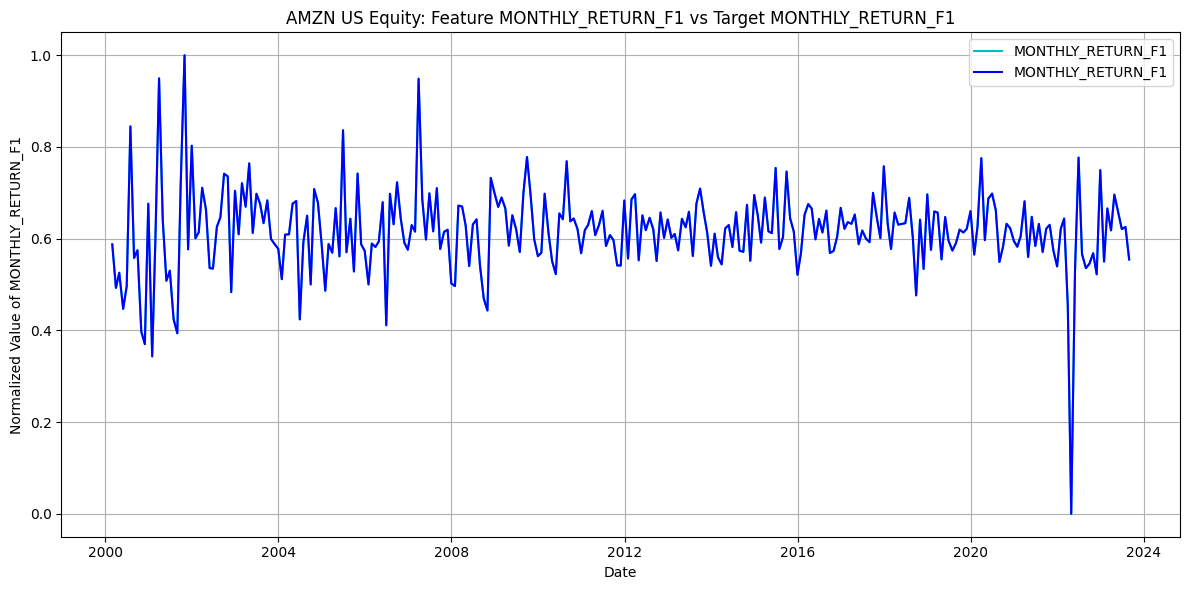

lag1_MONTHLY_RETURN_diff is numeric? True
lag1_MONTHLY_RETURN_log is numeric? True
lag1_ma5_MONTHLY_RETURN is numeric? True
lag1_ma10_MONTHLY_RETURN is numeric? True
lag1_ma15_MONTHLY_RETURN is numeric? True
lag1_RSI_MONTHLY_RETURN is numeric? True
lag1_MACD_MONTHLY_RETURN is numeric? True
lag1_MACD_signal_MONTHLY_RETURN is numeric? True
lag1_MONTHLY_RETURN_F1_diff is numeric? True
lendf: 283; lendf2: 283


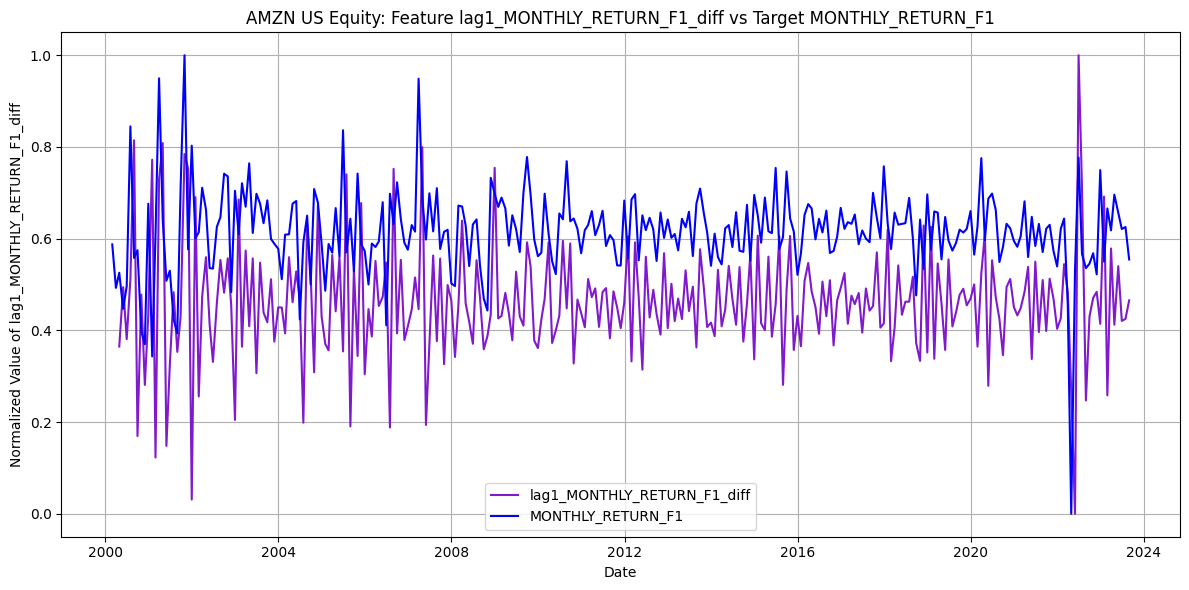

lag1_MONTHLY_RETURN_F1_log is numeric? True
lendf: 283; lendf2: 283


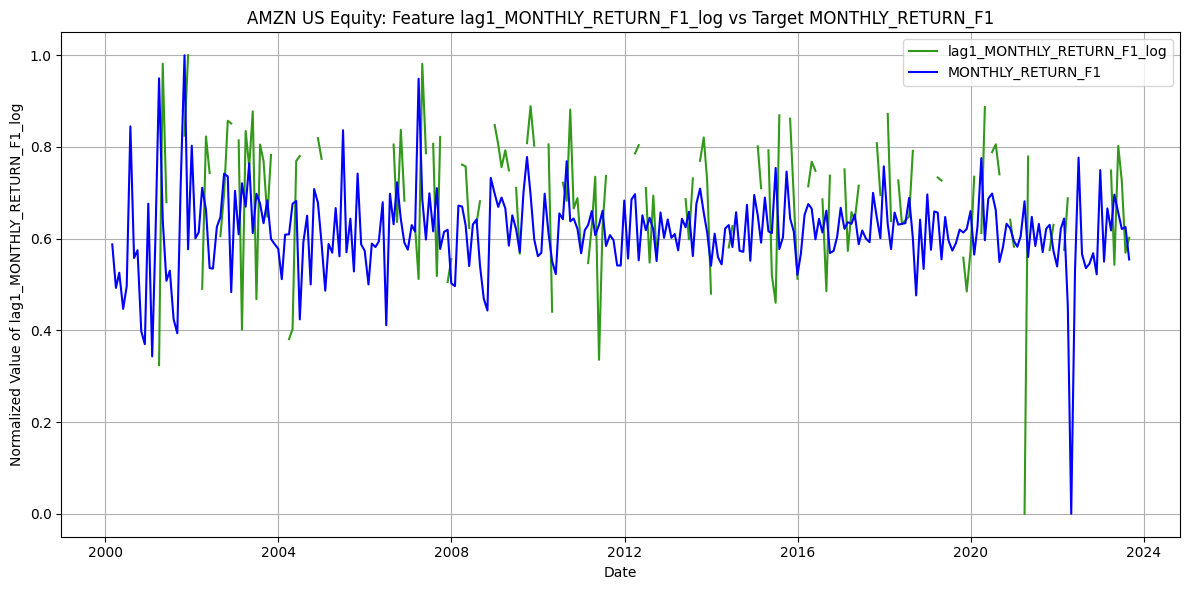

lag1_ma5_MONTHLY_RETURN_F1 is numeric? True
lendf: 283; lendf2: 283


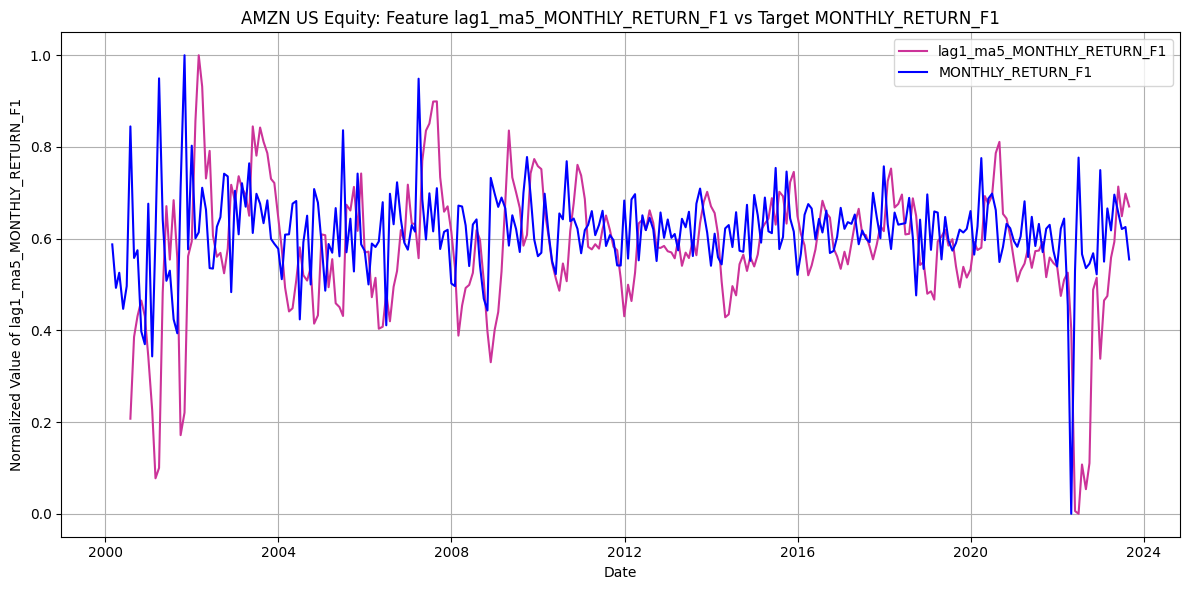

lag1_ma10_MONTHLY_RETURN_F1 is numeric? True
lendf: 283; lendf2: 283


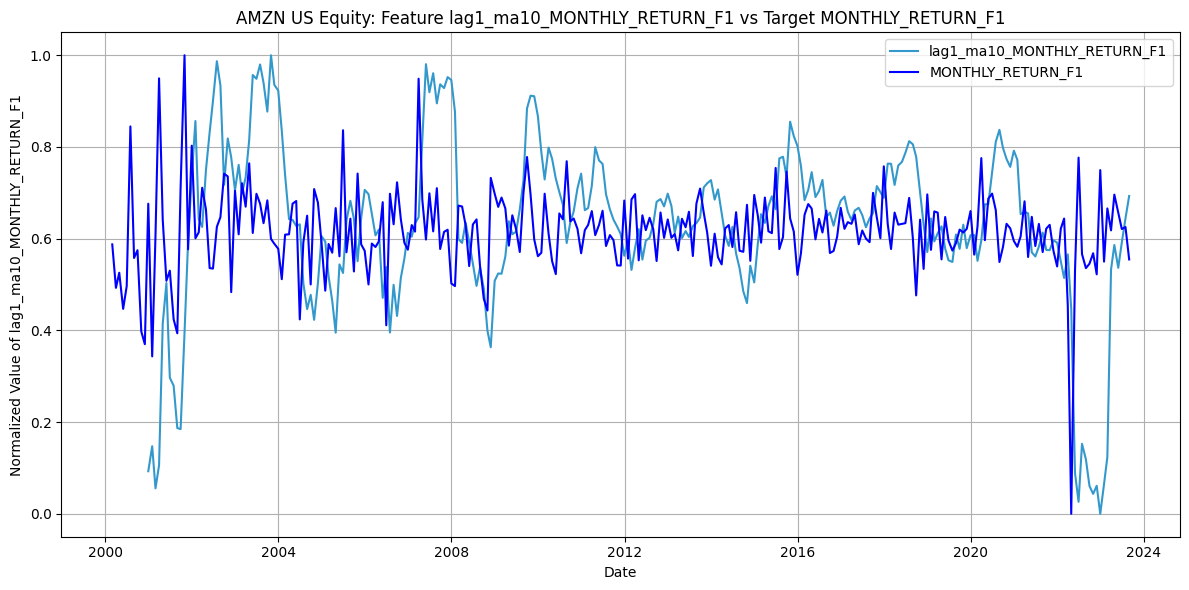

lag1_ma15_MONTHLY_RETURN_F1 is numeric? True
lendf: 283; lendf2: 283


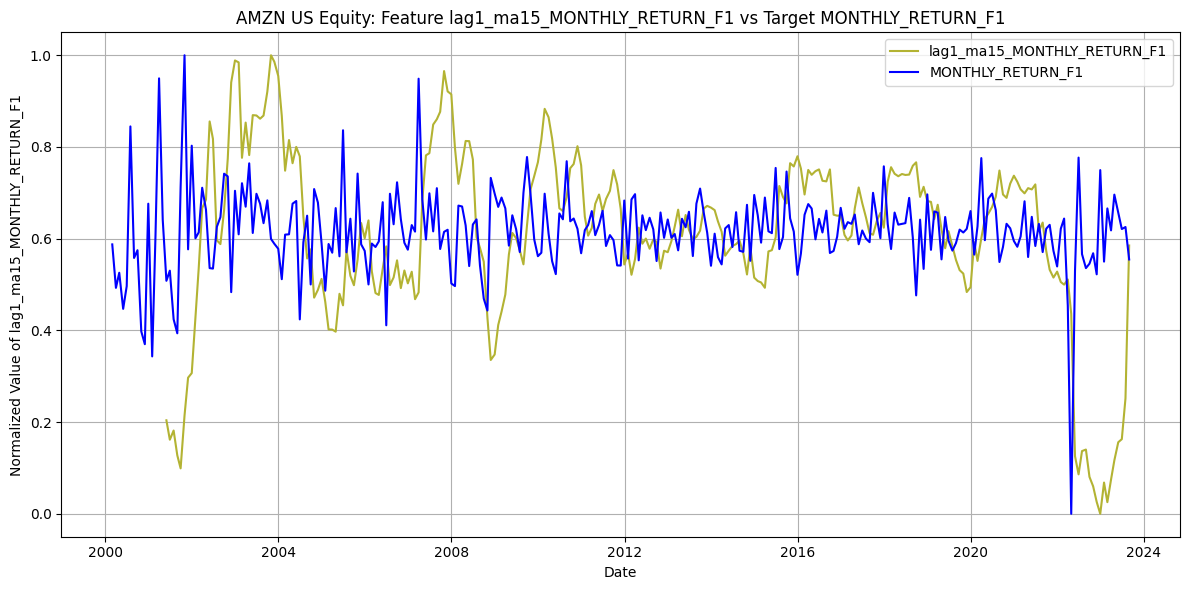

lag1_RSI_MONTHLY_RETURN_F1 is numeric? True
lendf: 283; lendf2: 283


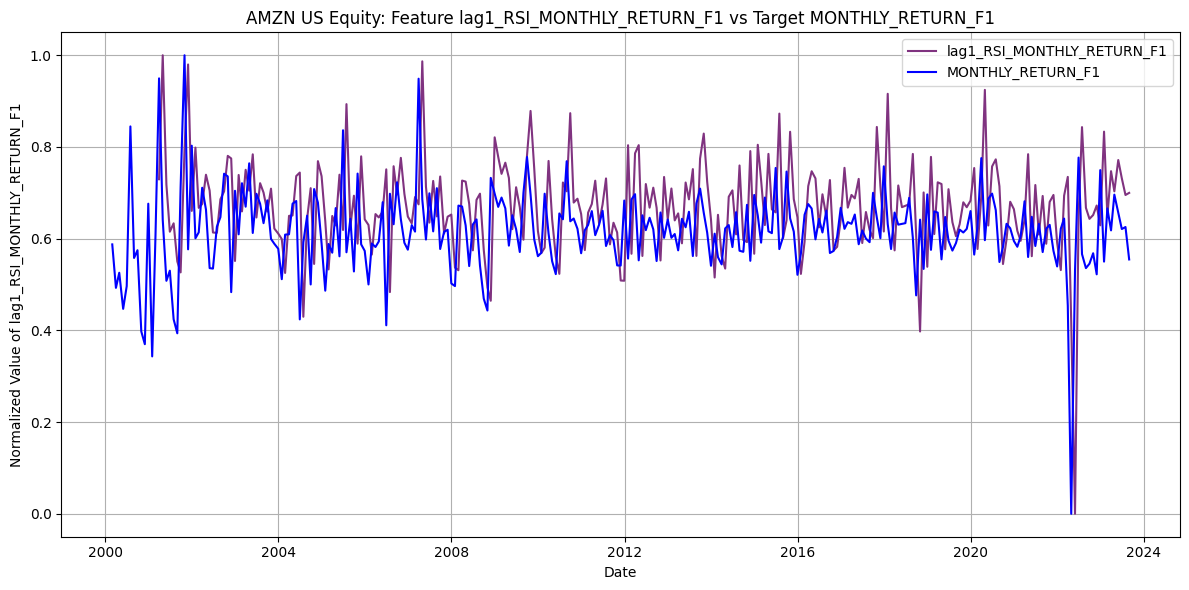

lag1_MACD_MONTHLY_RETURN_F1 is numeric? True
lendf: 283; lendf2: 283


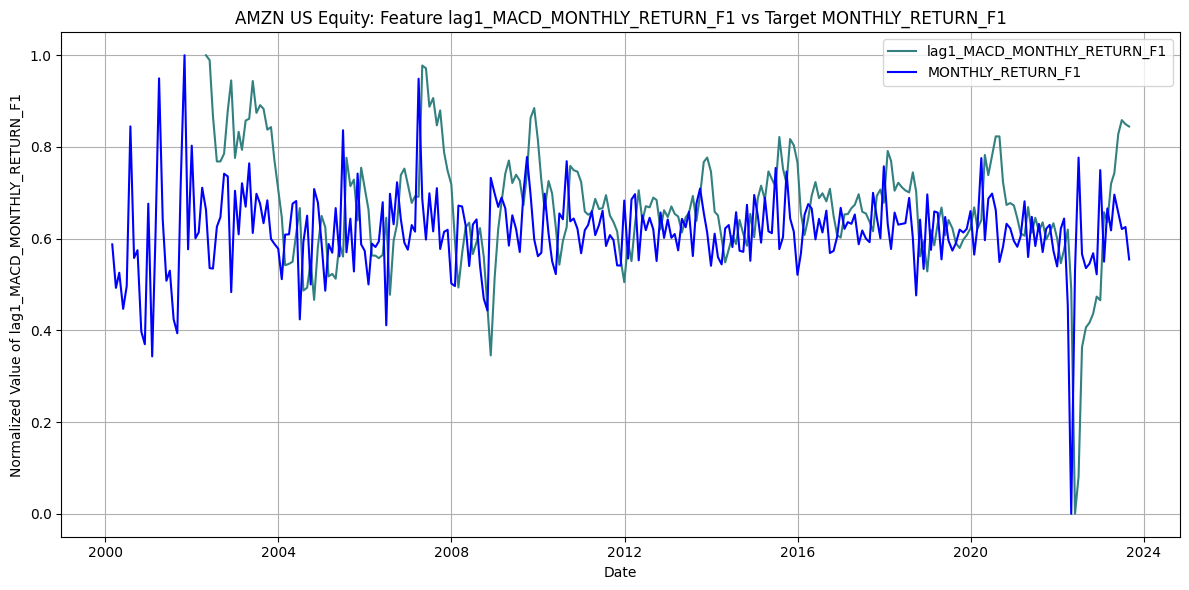

lag1_MACD_signal_MONTHLY_RETURN_F1 is numeric? True
lendf: 283; lendf2: 283


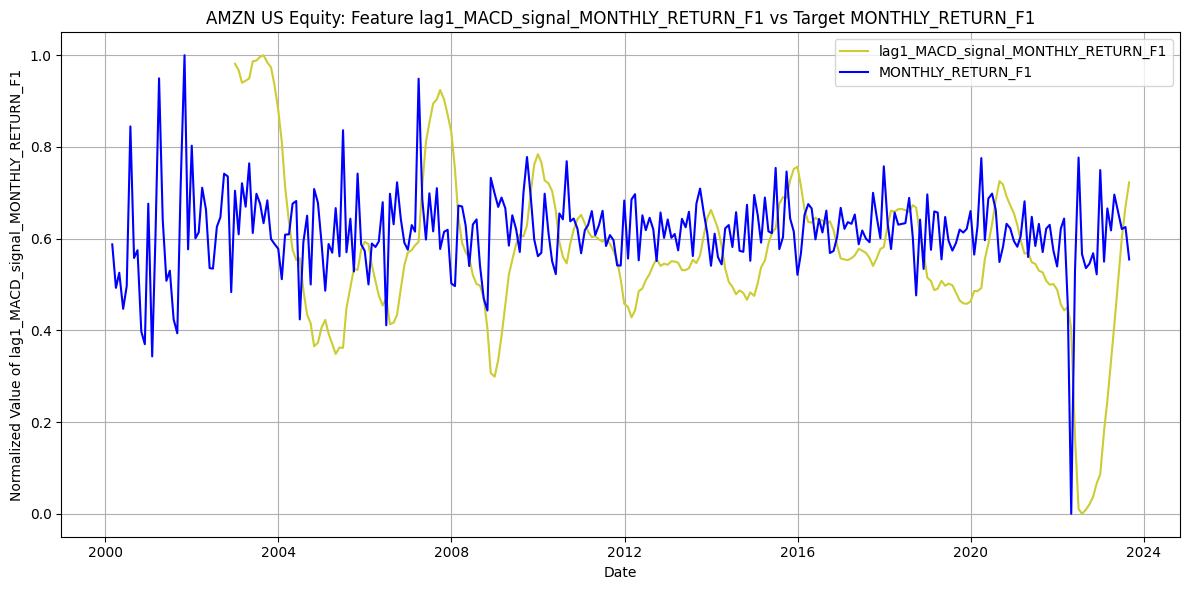

In [ ]:
trend(y_tech, y_tech, stock = 'AMZN US Equity', target = 'MONTHLY_RETURN_F1')

### Preprocess Company Factors:
* Drop columns in company factors data if more than 30% is null.

In [ ]:
cf_threshold = len(cf) * 0.7
cf = cf.dropna(thresh=cf_threshold, axis = 1)


In [ ]:
cf.columns

Index(['security', 'date', 'TRAIL_12M_NET_SALES', 'TRAIL_12M_EPS',
       'TRAIL_12M_OPER_MARGIN', 'EV_TO_T12M_EBITDA', 'ENTERPRISE_VALUE',
       'BEST_PE_RATIO', 'PX_LAST', 'BEST_SALES', 'BEST_EPS',
       'BEST_CUR_EV_TO_EBITDA', 'TRAIL_12M_EBITDA', 'CUR_MKT_CAP', 'VOLUME',
       'TRAIL_12M_GROSS_MARGIN', 'EBIT_MARGIN', 'BEST_LTG_EPS',
       'IS_DIV_PER_SHR', 'EBITDA_MARGIN', 'TOT_DEBT_TO_TOT_ASSET',
       'SALES_GROWTH', 'EPS_GROWTH', 'SALES_TO_CASH',
       'CURRENT_EV_TO_T12M_EBITDA', 'PE_RATIO', 'EQY_SH_OUT', 'SHORT_INT',
       'SI_PERCENT_EQUITY_FLOAT', 'RSK_BB_IMPLIED_CDS_SPREAD', 'IVOL_DELTA',
       'OPEN_INT_TOTAL_CALL', 'OPEN_INT_TOTAL_PUT', 'PX_TO_BOOK_RATIO',
       'TOT_DEBT_TO_TOT_EQY', 'TOT_DEBT_TO_EBITDA', 'RETURN_COM_EQY',
       'TANG_BOOK_VAL_PER_SH', 'NET_DEBT', 'BEST_EBITDA', 'TRAIL_12M_OPER_INC',
       'TRAIL_12M_CAP_EXPEND', 'FREE_CASH_FLOW_YIELD',
       'TRAIL_12M_FREE_CASH_FLOW_PER_SH'],
      dtype='object')

## Scrape price data
* the code is here since I used the preprocessed sentiment data as a reference to scrape the price data. Yet, when readers open the notebook, this part has been done already.
* the price data is already loaded into the notebook

In [ ]:
# scrape datewise price data from yahoo finance for each stock
def scrape_price_2000(df):
  price_dfs = []
  view = df.groupby(['security']).agg({'date':['min','max']}).reset_index()
  view.columns = ["_".join(row) for row in view.columns.ravel()]
  view.rename({'security_':'security', 'date_':'date'}, axis =1,  inplace = True)
  # security, date_min, date_max
  for i, row in view.iterrows():
    ticker = security2ticker[row['security']]
    start = row['date_min']
    end = row['date_max']
    print(f"downloading {row['security']}: {start}-{end}")
    price = yf.download(ticker, start, end)
    price['security'] = row['security']
    price_dfs.append(price)
  combined_prices = pd.concat(price_dfs)
  return combined_prices

if DATA_NOT_SCRAPED:
  price_data = scrape_price_2000(y_df)
  price_data = price_data.reset_index()
  if 'Date' in price_data.columns:
    price_data.rename({'Date':'date'}, axis = 1, inplace = True)
  price_data.to_csv('/content/gdrive/MyDrive/lazard/price_data_2000.csv', index = False)

## Join company factors data price data

In [ ]:
price_data

date        Open        High         Low       Close   Adj Close  \
0      2000-02-29    3.300000    3.448438    3.293750    3.443750    3.443750   
1      2000-03-01    3.381250    3.425000    3.250000    3.293750    3.293750   
2      2000-03-02    3.246875    3.250000    3.109375    3.128125    3.128125   
3      2000-03-03    3.162500    3.237500    3.103125    3.125000    3.125000   
4      2000-03-06    3.143750    3.362500    3.140625    3.196875    3.196875   
...           ...         ...         ...         ...         ...         ...   
133439 2023-09-22  124.650002  125.830002  124.099998  125.000000  125.000000   
133440 2023-09-25  124.519997  125.400002  124.269997  124.970001  124.970001   
133441 2023-09-26  124.239998  124.739998  123.449997  124.010002  124.010002   
133442 2023-09-27  124.010002  124.410004  121.139999  121.980003  121.980003   
133443 2023-09-28  121.699997  124.220001  121.540001  124.080002  124.080002   

           Volume        security  
0       142970000  AMZN US Equity  
1       111534000  AMZN US Equity  
2       159602000  AMZN US Equity  
3       121190000  AMZN US Equity  
4       153316000  AMZN US Equity  
...           ...             ...  
133439    1534100   YUM US Equity  
133440    1048500   YUM US Equity  
133441    1500600   YUM US Equity  
133442    1922300   YUM US Equity  
133443    1722700   YUM US Equity  

[133444 rows x 8 columns]

In [ ]:
cf

security       date  TRAIL_12M_NET_SALES  TRAIL_12M_EPS  \
0     AMZN US Equity 2000-01-31              1639.84        -1.1800   
1     AMZN US Equity 2000-02-29              1639.84        -1.1800   
2     AMZN US Equity 2000-03-31              1920.08        -1.4150   
3     AMZN US Equity 2000-04-28              1920.08        -1.4150   
4     AMZN US Equity 2000-05-31              1920.08        -1.4150   
...              ...        ...                  ...            ...   
6606   YUM US Equity 2023-06-30              6940.00         4.3958   
6607   YUM US Equity 2023-07-31              6991.00         4.8185   
6608   YUM US Equity 2023-08-31              6991.00         4.8185   
6609   YUM US Equity 2023-09-29              6991.00         4.8185   
6610   YUM US Equity 2023-10-27              6991.00         4.8185   

      TRAIL_12M_OPER_MARGIN  EV_TO_T12M_EBITDA  ENTERPRISE_VALUE  \
0                  -24.8902                NaN           27049.4   
1                  -24.8902                NaN           27049.4   
2                  -28.7724                NaN           24591.3   
3                  -28.7724                NaN           24591.3   
4                  -28.7724                NaN           24591.3   
...                     ...                ...               ...   
6606                31.7147            21.0023           49124.4   
6607                31.7551            21.4517           50669.0   
6608                31.7551            21.4517           50669.0   
6609                31.7551            21.4517           50669.0   
6610                31.7551            21.4517           50669.0   

      BEST_PE_RATIO  PX_LAST  BEST_SALES  ...  TOT_DEBT_TO_TOT_EQY  \
0               NaN   64.563         NaN  ...              556.058   
1               NaN   68.875         NaN  ...              556.058   
2               NaN   67.000         NaN  ...             8404.380   
3               NaN   55.188         NaN  ...             8404.380   
4               NaN   48.313         NaN  ...             8404.380   
...             ...      ...         ...  ...                  ...   
6606         26.097  138.550     7468.20  ...                  NaN   
6607         25.054  137.670     7593.94  ...                  NaN   
6608         23.670  129.380     7532.31  ...                  NaN   
6609         22.895  124.940     7529.59  ...                  NaN   
6610         21.264  119.440     7631.30  ...                  NaN   

      TOT_DEBT_TO_EBITDA  RETURN_COM_EQY  TANG_BOOK_VAL_PER_SH   NET_DEBT  \
0                    NaN         -355.52               -0.7777    774.472   
1                    NaN         -355.52               -0.7777    774.472   
2                    NaN        -1874.34               -1.7761   1144.060   
3                    NaN        -1874.34               -1.7761   1144.060   
4                    NaN        -1874.34               -1.7761   1144.060   
...                  ...             ...                   ...        ...   
6606              5.3403             NaN              -34.8714  12142.000   
6607              5.2125             NaN              -33.7357  11875.000   
6608              5.2125             NaN              -33.7357  11875.000   
6609              5.2125             NaN              -33.7357  11875.000   
6610              5.2125             NaN              -33.7357  11875.000   

      BEST_EBITDA  TRAIL_12M_OPER_INC  TRAIL_12M_CAP_EXPEND  \
0             NaN            -408.160              -287.055   
1             NaN            -408.160              -287.055   
2             NaN            -552.454              -294.594   
3             NaN            -552.454              -294.594   
4             NaN            -552.454              -294.594   
...           ...                 ...                   ...   
6606      2627.76            2201.000              -299.000   
6607      2676.99            2220.000              -304.000   
6608     

In [ ]:
# use the comp_factors data: duplicate/populate the montnly data of comp_factors on the corresponding days in that month in price
# one resulting row will contain the daily price and monthly company data
price_data['month'] = price_data['date'].dt.strftime('%Y-%m')
cf['month'] = cf['date'].dt.strftime('%Y-%m')
price_comp = pd.merge(price_data, cf, on = ['security', 'month'])


In [ ]:
price_comp.columns

Index(['date_x', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'security', 'month', 'date_y', 'TRAIL_12M_NET_SALES', 'TRAIL_12M_EPS',
       'TRAIL_12M_OPER_MARGIN', 'EV_TO_T12M_EBITDA', 'ENTERPRISE_VALUE',
       'BEST_PE_RATIO', 'PX_LAST', 'BEST_SALES', 'BEST_EPS',
       'BEST_CUR_EV_TO_EBITDA', 'TRAIL_12M_EBITDA', 'CUR_MKT_CAP', 'VOLUME',
       'TRAIL_12M_GROSS_MARGIN', 'EBIT_MARGIN', 'BEST_LTG_EPS',
       'IS_DIV_PER_SHR', 'EBITDA_MARGIN', 'TOT_DEBT_TO_TOT_ASSET',
       'SALES_GROWTH', 'EPS_GROWTH', 'SALES_TO_CASH',
       'CURRENT_EV_TO_T12M_EBITDA', 'PE_RATIO', 'EQY_SH_OUT', 'SHORT_INT',
       'SI_PERCENT_EQUITY_FLOAT', 'RSK_BB_IMPLIED_CDS_SPREAD', 'IVOL_DELTA',
       'OPEN_INT_TOTAL_CALL', 'OPEN_INT_TOTAL_PUT', 'PX_TO_BOOK_RATIO',
       'TOT_DEBT_TO_TOT_EQY', 'TOT_DEBT_TO_EBITDA', 'RETURN_COM_EQY',
       'TANG_BOOK_VAL_PER_SH', 'NET_DEBT', 'BEST_EBITDA', 'TRAIL_12M_OPER_INC',
       'TRAIL_12M_CAP_EXPEND', 'FREE_CASH_FLOW_YIELD',
       'TRAIL_12M_FREE_CA

In [ ]:
price_comp.drop(['date_y'], axis = 1, inplace = True) # date_y is the month's end date
price_comp.rename({'date_x':'date'}, axis = 1, inplace = True) # x is the date when the price was listed
price_comp.columns

Index(['date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'security', 'month', 'TRAIL_12M_NET_SALES', 'TRAIL_12M_EPS',
       'TRAIL_12M_OPER_MARGIN', 'EV_TO_T12M_EBITDA', 'ENTERPRISE_VALUE',
       'BEST_PE_RATIO', 'PX_LAST', 'BEST_SALES', 'BEST_EPS',
       'BEST_CUR_EV_TO_EBITDA', 'TRAIL_12M_EBITDA', 'CUR_MKT_CAP', 'VOLUME',
       'TRAIL_12M_GROSS_MARGIN', 'EBIT_MARGIN', 'BEST_LTG_EPS',
       'IS_DIV_PER_SHR', 'EBITDA_MARGIN', 'TOT_DEBT_TO_TOT_ASSET',
       'SALES_GROWTH', 'EPS_GROWTH', 'SALES_TO_CASH',
       'CURRENT_EV_TO_T12M_EBITDA', 'PE_RATIO', 'EQY_SH_OUT', 'SHORT_INT',
       'SI_PERCENT_EQUITY_FLOAT', 'RSK_BB_IMPLIED_CDS_SPREAD', 'IVOL_DELTA',
       'OPEN_INT_TOTAL_CALL', 'OPEN_INT_TOTAL_PUT', 'PX_TO_BOOK_RATIO',
       'TOT_DEBT_TO_TOT_EQY', 'TOT_DEBT_TO_EBITDA', 'RETURN_COM_EQY',
       'TANG_BOOK_VAL_PER_SH', 'NET_DEBT', 'BEST_EBITDA', 'TRAIL_12M_OPER_INC',
       'TRAIL_12M_CAP_EXPEND', 'FREE_CASH_FLOW_YIELD',
       'TRAIL_12M_FREE_CASH_FLOW_PER_

In [ ]:
price_comp.shape

(133444, 51)

In [ ]:
price_comp.head()

date      Open      High       Low     Close  Adj Close     Volume  \
0 2000-02-29  3.300000  3.448438  3.293750  3.443750   3.443750  142970000   
1 2000-03-01  3.381250  3.425000  3.250000  3.293750   3.293750  111534000   
2 2000-03-02  3.246875  3.250000  3.109375  3.128125   3.128125  159602000   
3 2000-03-03  3.162500  3.237500  3.103125  3.125000   3.125000  121190000   
4 2000-03-06  3.143750  3.362500  3.140625  3.196875   3.196875  153316000   

         security    month  TRAIL_12M_NET_SALES  ...  TOT_DEBT_TO_TOT_EQY  \
0  AMZN US Equity  2000-02              1639.84  ...              556.058   
1  AMZN US Equity  2000-03              1920.08  ...             8404.380   
2  AMZN US Equity  2000-03              1920.08  ...             8404.380   
3  AMZN US Equity  2000-03              1920.08  ...             8404.380   
4  AMZN US Equity  2000-03              1920.08  ...             8404.380   

   TOT_DEBT_TO_EBITDA  RETURN_COM_EQY  TANG_BOOK_VAL_PER_SH  NET_DEBT  \
0                 NaN         -355.52               -0.7777   774.472   
1                 NaN        -1874.34               -1.7761  1144.060   
2                 NaN        -1874.34               -1.7761  1144.060   
3                 NaN        -1874.34               -1.7761  1144.060   
4                 NaN        -1874.34               -1.7761  1144.060   

   BEST_EBITDA  TRAIL_12M_OPER_INC  TRAIL_12M_CAP_EXPEND  \
0          NaN            -408.160              -287.055   
1          NaN            -552.454              -294.594   
2          NaN            -552.454              -294.594   
3          NaN            -552.454              -294.594   
4          NaN            -552.454              -294.594   

   FREE_CASH_FLOW_YIELD  TRAIL_12M_FREE_CASH_FLOW_PER_SH  
0               -1.6709                          -1.1508  
1               -3.0512                          -2.0443  
2               -3.0512                          -2.0443  
3               -3.0512                          -2.0443  
4               -3.0512                          -2.0443  

[5 rows x 51 columns]

# Train-Test Split
Data: sentiment, price and its extended features, y's extended features

### Take out rows in y_df (label data) where we have no features.

In [ ]:
y_df['month'] = y_df['date'].dt.strftime('%Y-%m')

In [ ]:
y_df.head(5)

security       date  MONTHLY_RETURN  MONTHLY_RETURN_F1    month
1  AMZN US Equity 2000-02-29        0.066787          -0.027223  2000-02
2  AMZN US Equity 2000-03-31       -0.027223          -0.176299  2000-03
3  AMZN US Equity 2000-04-28       -0.176299          -0.124574  2000-04
4  AMZN US Equity 2000-05-31       -0.124574          -0.248380  2000-05
5  AMZN US Equity 2000-06-30       -0.248380          -0.170407  2000-06

In [ ]:
# inner join y and X data to eliminate the rows where there is no features
y_df['month'] = y_df['date'].dt.strftime('%Y-%m')
X_y = pd.merge(price_comp[['security',	'month']], y_df, on = ['security', 'month'])
X_y.sort_values(by = ['security', 'month','date'], inplace = True)


In [ ]:
X_y

security    month       date  MONTHLY_RETURN  MONTHLY_RETURN_F1
0       AMZN US Equity  2000-02 2000-02-29        0.066787          -0.027223
1       AMZN US Equity  2000-03 2000-03-31       -0.027223          -0.176299
2       AMZN US Equity  2000-03 2000-03-31       -0.027223          -0.176299
3       AMZN US Equity  2000-03 2000-03-31       -0.027223          -0.176299
4       AMZN US Equity  2000-03 2000-03-31       -0.027223          -0.176299
...                ...      ...        ...             ...                ...
133439   YUM US Equity  2023-09 2023-09-29       -0.034318          -0.044021
133440   YUM US Equity  2023-09 2023-09-29       -0.034318          -0.044021
133441   YUM US Equity  2023-09 2023-09-29       -0.034318          -0.044021
133442   YUM US Equity  2023-09 2023-09-29       -0.034318          -0.044021
133443   YUM US Equity  2023-09 2023-09-29       -0.034318          -0.044021

[133444 rows x 5 columns]

In [ ]:
print(f'before dropping dup: size y = {len(X_y)}')
X_y.drop_duplicates(inplace = True)
X_y.reset_index(inplace = True)
y = X_y
print(f'after dropping dup: size y = {len(X_y)}')

before dropping dup: size y = 133444
after dropping dup: size y = 6388


In [ ]:
comp_cols = ['TRAIL_12M_NET_SALES', 'TRAIL_12M_EPS',
       'TRAIL_12M_OPER_MARGIN', 'EV_TO_T12M_EBITDA', 'ENTERPRISE_VALUE',
       'BEST_PE_RATIO', 'PX_LAST', 'BEST_SALES', 'BEST_EPS',
       'BEST_CUR_EV_TO_EBITDA', 'TRAIL_12M_EBITDA', 'CUR_MKT_CAP', 'VOLUME',
       'TRAIL_12M_GROSS_MARGIN', 'EBIT_MARGIN', 'BEST_LTG_EPS',
       'IS_DIV_PER_SHR', 'EBITDA_MARGIN', 'TOT_DEBT_TO_TOT_ASSET',
       'SALES_GROWTH', 'EPS_GROWTH', 'SALES_TO_CASH',
       'CURRENT_EV_TO_T12M_EBITDA', 'PE_RATIO', 'EQY_SH_OUT', 'SHORT_INT',
       'SI_PERCENT_EQUITY_FLOAT', 'RSK_BB_IMPLIED_CDS_SPREAD', 'IVOL_DELTA',
       'OPEN_INT_TOTAL_CALL', 'OPEN_INT_TOTAL_PUT', 'PX_TO_BOOK_RATIO',
       'TOT_DEBT_TO_TOT_EQY', 'TOT_DEBT_TO_EBITDA', 'RETURN_COM_EQY',
       'TANG_BOOK_VAL_PER_SH', 'NET_DEBT', 'BEST_EBITDA', 'TRAIL_12M_OPER_INC',
       'TRAIL_12M_CAP_EXPEND', 'FREE_CASH_FLOW_YIELD',
       'TRAIL_12M_FREE_CASH_FLOW_PER_SH']

#### decide if we want company data in the features:

In [ ]:
NO_COMP = False # later drop company data during training

In [ ]:
if NO_COMP == True:
  price_comp = price_comp.drop(comp_cols, axis = 1)
  X = price_comp
else:
  X = price_comp

In [ ]:
X.columns

Index(['date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'security', 'month', 'TRAIL_12M_NET_SALES', 'TRAIL_12M_EPS',
       'TRAIL_12M_OPER_MARGIN', 'EV_TO_T12M_EBITDA', 'ENTERPRISE_VALUE',
       'BEST_PE_RATIO', 'PX_LAST', 'BEST_SALES', 'BEST_EPS',
       'BEST_CUR_EV_TO_EBITDA', 'TRAIL_12M_EBITDA', 'CUR_MKT_CAP', 'VOLUME',
       'TRAIL_12M_GROSS_MARGIN', 'EBIT_MARGIN', 'BEST_LTG_EPS',
       'IS_DIV_PER_SHR', 'EBITDA_MARGIN', 'TOT_DEBT_TO_TOT_ASSET',
       'SALES_GROWTH', 'EPS_GROWTH', 'SALES_TO_CASH',
       'CURRENT_EV_TO_T12M_EBITDA', 'PE_RATIO', 'EQY_SH_OUT', 'SHORT_INT',
       'SI_PERCENT_EQUITY_FLOAT', 'RSK_BB_IMPLIED_CDS_SPREAD', 'IVOL_DELTA',
       'OPEN_INT_TOTAL_CALL', 'OPEN_INT_TOTAL_PUT', 'PX_TO_BOOK_RATIO',
       'TOT_DEBT_TO_TOT_EQY', 'TOT_DEBT_TO_EBITDA', 'RETURN_COM_EQY',
       'TANG_BOOK_VAL_PER_SH', 'NET_DEBT', 'BEST_EBITDA', 'TRAIL_12M_OPER_INC',
       'TRAIL_12M_CAP_EXPEND', 'FREE_CASH_FLOW_YIELD',
       'TRAIL_12M_FREE_CASH_FLOW_PER_

### get y_train and y_val

In [ ]:
# first, get the y_train and y_val, then later based on that I will get X_train and X_val
# Create empty lists to store data for each stock
y_train_list = []
y_val_list = []

# Group the data by 'security' column
grouped = y.groupby('security')

for security, data in grouped:
    # Sort the data by the time (date) column
    data = data.sort_values(by='date')

    # Calculate the index for the 80% point
    split_index = int(0.8 * len(data))

    # Split the data into training and validation sets
    y_train, y_val = data.iloc[:split_index], data.iloc[split_index:]

    # Append data for the current stock to the lists
    y_train_list.append(y_train)
    y_val_list.append(y_val)

# Concatenate the individual DataFrames for each stock
y_train = pd.concat(y_train_list)
y_val = pd.concat(y_val_list)

# Reset index for the final DataFrames
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

# Print the shapes of the resulting DataFrames
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


y_train shape: (5100, 6)
y_val shape: (1288, 6)


### get X_train, X_val
* by selecting rows whose date is ealier than the max date under the stock group in y_train and y_val

In [ ]:
y_train[y_train['security']=='AMZN US Equity'].tail()

index        security    month       date  MONTHLY_RETURN  \
221   4614  AMZN US Equity  2018-07 2018-07-31        0.045676   
222   4635  AMZN US Equity  2018-08 2018-08-31        0.132365   
223   4658  AMZN US Equity  2018-09 2018-09-28       -0.004824   
224   4677  AMZN US Equity  2018-10 2018-10-31       -0.202192   
225   4700  AMZN US Equity  2018-11 2018-11-30        0.057672   

     MONTHLY_RETURN_F1  
221           0.132365  
222          -0.004824  
223          -0.202192  
224           0.057672  
225          -0.111350

In [ ]:
y_val[y_val['security']=='AMZN US Equity'].head()

index        security    month       date  MONTHLY_RETURN  \
0   4721  AMZN US Equity  2018-12 2018-12-31       -0.111350   
1   4740  AMZN US Equity  2019-01 2019-01-31        0.144317   
2   4761  AMZN US Equity  2019-02 2019-02-28       -0.045906   
3   4780  AMZN US Equity  2019-03 2019-03-29        0.085936   
4   4801  AMZN US Equity  2019-04 2019-04-30        0.081859   

   MONTHLY_RETURN_F1  
0           0.144317  
1          -0.045906  
2           0.085936  
3           0.081859  
4          -0.078613

In [ ]:
# Then, split X into train and validation set.
# find the max date in y_train for all stocks: then in the X data, any row of that stock earlier than that max date is the X_train
y_train_range = y_train.groupby(['security'])['date'].max().reset_index()
map_y_train_range = {}
for i, row in y_train_range.iterrows():
  map_y_train_range[row['security']] = row['date']


In [ ]:
# X_train contains all the rows where the date is earlier than/equal to the max_date in y_train (stratified in terms of security)
X_train = X.groupby(['security']).apply(lambda x: x[x['date']<= map_y_train_range[x.name]]).reset_index(drop = True)
# X_validation contains all the rows where the date is later than the max_date in y_train (stratified in terms of security)
X_val =  X.groupby(['security']).apply(lambda x: x[x['date'] > map_y_train_range[x.name]]).reset_index(drop = True)

#### From below you can see the correspondence between X_train vs y_train; X_val vs y_val

In [ ]:
X_train[X_train['security']=='AMZN US Equity'].tail()

date       Open       High        Low      Close  Adj Close  \
4716 2018-11-26  76.949997  79.240501  76.210999  79.066498  79.066498   
4717 2018-11-27  78.799500  79.882500  77.900497  79.070999  79.070999   
4718 2018-11-28  80.695999  84.072502  80.060997  83.887497  83.887497   
4719 2018-11-29  83.749496  84.499496  82.616501  83.678497  83.678497   
4720 2018-11-30  83.974998  84.800003  83.324997  84.508499  84.508499   

         Volume        security    month  TRAIL_12M_NET_SALES  ...  \
4716  125154000  AMZN US Equity  2018-11             220957.0  ...   
4717  115664000  AMZN US Equity  2018-11             220957.0  ...   
4718  169174000  AMZN US Equity  2018-11             220957.0  ...   
4719  132264000  AMZN US Equity  2018-11             220957.0  ...   
4720  115236000  AMZN US Equity  2018-11             220957.0  ...   

      TOT_DEBT_TO_TOT_EQY  TOT_DEBT_TO_EBITDA  RETURN_COM_EQY  \
4716               112.23               1.733         27.9134   
4717               112.23               1.733         27.9134   
4718               112.23               1.733         27.9134   
4719               112.23               1.733         27.9134   
4720               112.23               1.733         27.9134   

      TANG_BOOK_VAL_PER_SH  NET_DEBT  BEST_EBITDA  TRAIL_12M_OPER_INC  \
4716               50.2495   14145.0      38844.3             10761.0   
4717               50.2495   14145.0      38844.3             10761.0   
4718               50.2495   14145.0      38844.3             10761.0   
4719               50.2495   14145.0      38844.3             10761.0   
4720               50.2495   14145.0      38844.3             10761.0   

      TRAIL_12M_CAP_EXPEND  FREE_CASH_FLOW_YIELD  \
4716              -13313.0                1.6195   
4717              -13313.0                1.6195   
4718              -13313.0                1.6195   
4719              -13313.0                1.6195   
4720              -13313.0                1.6195   

      TRAIL_12M_FREE_CASH_FLOW_PER_SH  
4716                          27.3716  
4717                          27.3716  
4718                          27.3716  
4719                          27.3716  
4720                          27.3716  

[5 rows x 51 columns]

In [ ]:
X_val[X_val['security']=='AMZN US Equity'].head()

date       Open       High        Low      Close  Adj Close  \
0 2018-12-03  88.473000  88.917000  86.500000  88.617996  88.617996   
1 2018-12-04  87.800003  88.516998  83.250000  83.419998  83.419998   
2 2018-12-06  80.743500  85.052498  80.492500  84.959503  84.959503   
3 2018-12-07  85.253502  85.946503  81.273003  81.456497  81.456497   
4 2018-12-10  81.192001  82.899498  79.543503  82.051498  82.051498   

      Volume        security    month  TRAIL_12M_NET_SALES  ...  \
0  137246000  AMZN US Equity  2018-12             232887.0  ...   
1  173890000  AMZN US Equity  2018-12             232887.0  ...   
2  175788000  AMZN US Equity  2018-12             232887.0  ...   
3  151522000  AMZN US Equity  2018-12             232887.0  ...   
4  149896000  AMZN US Equity  2018-12             232887.0  ...   

   TOT_DEBT_TO_TOT_EQY  TOT_DEBT_TO_EBITDA  RETURN_COM_EQY  \
0              113.181              1.7755         28.2719   
1              113.181              1.7755         28.2719   
2              113.181              1.7755         28.2719   
3              113.181              1.7755         28.2719   
4              113.181              1.7755         28.2719   

   TANG_BOOK_VAL_PER_SH  NET_DEBT  BEST_EBITDA  TRAIL_12M_OPER_INC  \
0               50.6945    8039.0      38940.2             12420.0   
1               50.6945    8039.0      38940.2             12420.0   
2               50.6945    8039.0      38940.2             12420.0   
3               50.6945    8039.0      38940.2             12420.0   
4               50.6945    8039.0      38940.2             12420.0   

   TRAIL_12M_CAP_EXPEND  FREE_CASH_FLOW_YIELD  TRAIL_12M_FREE_CASH_FLOW_PER_SH  
0              -13426.0                2.3498                          35.2928  
1              -13426.0                2.3498                          35.2928  
2              -13426.0                2.3498                          35.2928  
3              -13426.0                2.3498                          35.2928  
4              -13426.0                2.3498                          35.2928  

[5 rows x 51 columns]

### check

In [ ]:
data_lengths = {
    'Dataset': ['X_train', 'X_val', 'y_train', 'y_val'],
    'Length': [len(X_train), len(X_val), len(y_train), len(y_val)]
}

length_df = pd.DataFrame(data_lengths)
length_df

Dataset  Length
0  X_train  106481
1    X_val   26963
2  y_train    5100
3    y_val    1288

In [ ]:
def check_composition(X_train, X_val, y_train, y_val):
  datasets = {
      'X_train': X_train['security'].value_counts(),
      'X_val': X_val['security'].value_counts(),
      'y_train': y_train['security'].value_counts(),
      'y_val': y_val['security'].value_counts()
  }

  # Create a DataFrame from the datasets dictionary
  table = pd.DataFrame(datasets)
  return table

In [ ]:
table = check_composition(X_train, X_val, y_train, y_val)
table

X_train  X_val  y_train  y_val
AMZN US Equity     4721   1193      226     57
APTV US Equity     2327    608      112     29
AZO US Equity      4721   1193      226     57
BKNG US Equity     4721   1193      226     57
CCL US Equity      4721   1193      226     57
CMG US Equity      3506    901      168     43
DG US Equity       2748    691      132     33
EBAY US Equity     4721   1193      226     57
F US Equity        4721   1193      226     57
GM US Equity       2537    650      122     31
HD US Equity       4721   1193      226     57
HLT US Equity      1910    502       92     24
LOW US Equity      4721   1193      226     57
LVS US Equity      3735    943      179     45
MAR US Equity      4721   1193      226     57
MCD US Equity      4721   1193      226     57
NKE US Equity      4721   1193      226     57
ORLY US Equity     4721   1193      226     57
RCL US Equity      4721   1193      226     57
ROST US Equity     4721   1193      226     57
SBUX US Equity     4721   1193      226     57
TGT US Equity      4721   1193      226     57
TJX US Equity      4721   1193      226     57
VFC US Equity      4721   1193      226     57
YUM US Equity      4740   1194      227     57

In [ ]:
table.sum(axis = 0)

X_train    106481
X_val       26963
y_train      5100
y_val        1288
dtype: int64

In [ ]:
# safe copies
y_val_original = y_val
X_val_origianl = X_val

In [ ]:
y_val_original

index        security    month       date  MONTHLY_RETURN  \
0       4721  AMZN US Equity  2018-12 2018-12-31       -0.111350   
1       4740  AMZN US Equity  2019-01 2019-01-31        0.144317   
2       4761  AMZN US Equity  2019-02 2019-02-28       -0.045906   
3       4780  AMZN US Equity  2019-03 2019-03-29        0.085936   
4       4801  AMZN US Equity  2019-04 2019-04-30        0.081859   
...      ...             ...      ...        ...             ...   
1283  133339   YUM US Equity  2023-05 2023-05-31       -0.084578   
1284  133361   YUM US Equity  2023-06 2023-06-30        0.076618   
1285  133382   YUM US Equity  2023-07 2023-07-31       -0.006351   
1286  133402   YUM US Equity  2023-08 2023-08-31       -0.060216   
1287  133425   YUM US Equity  2023-09 2023-09-29       -0.034318   

      MONTHLY_RETURN_F1  
0              0.144317  
1             -0.045906  
2              0.085936  
3              0.081859  
4             -0.078613  
...                 ...  
1283           0.076618  
1284          -0.006351  
1285          -0.060216  
1286          -0.034318  
1287          -0.044021  

[1288 rows x 6 columns]

In [ ]:
X_val.columns

Index(['date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'security', 'month', 'TRAIL_12M_NET_SALES', 'TRAIL_12M_EPS',
       'TRAIL_12M_OPER_MARGIN', 'EV_TO_T12M_EBITDA', 'ENTERPRISE_VALUE',
       'BEST_PE_RATIO', 'PX_LAST', 'BEST_SALES', 'BEST_EPS',
       'BEST_CUR_EV_TO_EBITDA', 'TRAIL_12M_EBITDA', 'CUR_MKT_CAP', 'VOLUME',
       'TRAIL_12M_GROSS_MARGIN', 'EBIT_MARGIN', 'BEST_LTG_EPS',
       'IS_DIV_PER_SHR', 'EBITDA_MARGIN', 'TOT_DEBT_TO_TOT_ASSET',
       'SALES_GROWTH', 'EPS_GROWTH', 'SALES_TO_CASH',
       'CURRENT_EV_TO_T12M_EBITDA', 'PE_RATIO', 'EQY_SH_OUT', 'SHORT_INT',
       'SI_PERCENT_EQUITY_FLOAT', 'RSK_BB_IMPLIED_CDS_SPREAD', 'IVOL_DELTA',
       'OPEN_INT_TOTAL_CALL', 'OPEN_INT_TOTAL_PUT', 'PX_TO_BOOK_RATIO',
       'TOT_DEBT_TO_TOT_EQY', 'TOT_DEBT_TO_EBITDA', 'RETURN_COM_EQY',
       'TANG_BOOK_VAL_PER_SH', 'NET_DEBT', 'BEST_EBITDA', 'TRAIL_12M_OPER_INC',
       'TRAIL_12M_CAP_EXPEND', 'FREE_CASH_FLOW_YIELD',
       'TRAIL_12M_FREE_CASH_FLOW_PER_

## Feature-engineering

### Actually Compute the set of price features experimented earlier

In [ ]:
# save checkpoint before feature engineering
X_train_beforefe = X_train
X_val_beforefe = X_val
y_train_beforefe = y_train
y_val_beforefe = y_val

In [ ]:
table1 = check_composition(X_train_beforefe, X_val_beforefe, y_train_beforefe, y_val_beforefe)
table1

X_train  X_val  y_train  y_val
AMZN US Equity     4721   1193      226     57
APTV US Equity     2327    608      112     29
AZO US Equity      4721   1193      226     57
BKNG US Equity     4721   1193      226     57
CCL US Equity      4721   1193      226     57
CMG US Equity      3506    901      168     43
DG US Equity       2748    691      132     33
EBAY US Equity     4721   1193      226     57
F US Equity        4721   1193      226     57
GM US Equity       2537    650      122     31
HD US Equity       4721   1193      226     57
HLT US Equity      1910    502       92     24
LOW US Equity      4721   1193      226     57
LVS US Equity      3735    943      179     45
MAR US Equity      4721   1193      226     57
MCD US Equity      4721   1193      226     57
NKE US Equity      4721   1193      226     57
ORLY US Equity     4721   1193      226     57
RCL US Equity      4721   1193      226     57
ROST US Equity     4721   1193      226     57
SBUX US Equity     4721   1193      226     57
TGT US Equity      4721   1193      226     57
TJX US Equity      4721   1193      226     57
VFC US Equity      4721   1193      226     57
YUM US Equity      4740   1194      227     57

In [ ]:
X_train = technical_features_price(X_train)


<ipython-input-12-da7ec0d85588>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security['daily_return'] = df_security['Close'] / df_security['Open'] - 1
<ipython-input-12-da7ec0d85588>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security['price_diff'] = df_security['Close'].diff(1)
<ipython-input-12-da7ec0d85588>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
X_val = technical_features_price(X_val)

<ipython-input-12-da7ec0d85588>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security['daily_return'] = df_security['Close'] / df_security['Open'] - 1
<ipython-input-12-da7ec0d85588>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security['price_diff'] = df_security['Close'].diff(1)
<ipython-input-12-da7ec0d85588>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

### Actually Compute the set of label features experimented earlier

In [ ]:
y_train = technical_features_label(y_train)

AMZN US Equity: size = (226, 6)
APTV US Equity: size = (112, 6)
AZO US Equity: size = (226, 6)
BKNG US Equity: size = (226, 6)


<ipython-input-13-a9b202ca7c8c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_{col}_diff'] = shifted_col.diff(1)
<ipython-input-13-a9b202ca7c8c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_{col}_log'] = shifted_col.apply(np.log)
<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

CCL US Equity: size = (226, 6)
CMG US Equity: size = (168, 6)
DG US Equity: size = (132, 6)
EBAY US Equity: size = (226, 6)


<ipython-input-13-a9b202ca7c8c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_{col}_log'] = shifted_col.apply(np.log)
<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_ma{period}_{col}'] = shifted_col.rolling(window=period).mean()
<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

F US Equity: size = (226, 6)
GM US Equity: size = (122, 6)
HD US Equity: size = (226, 6)
HLT US Equity: size = (92, 6)
LOW US Equity: size = (226, 6)


<ipython-input-13-a9b202ca7c8c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_MACD_{col}'] = ta.trend.macd(shifted_col, window_slow=ws, window_fast=wf)
<ipython-input-13-a9b202ca7c8c>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_MACD_signal_{col}'] = ta.trend.macd_signal(shifted_col, window_slow=ws, window_fast=wf)
<ipython-input-13-a9b202ca7c8c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

LVS US Equity: size = (179, 6)
MAR US Equity: size = (226, 6)
MCD US Equity: size = (226, 6)
NKE US Equity: size = (226, 6)


<ipython-input-13-a9b202ca7c8c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_{col}_diff'] = shifted_col.diff(1)
<ipython-input-13-a9b202ca7c8c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_{col}_log'] = shifted_col.apply(np.log)
<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

ORLY US Equity: size = (226, 6)
RCL US Equity: size = (226, 6)
ROST US Equity: size = (226, 6)
SBUX US Equity: size = (226, 6)


<ipython-input-13-a9b202ca7c8c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_{col}_diff'] = shifted_col.diff(1)
<ipython-input-13-a9b202ca7c8c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_{col}_log'] = shifted_col.apply(np.log)
<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

TGT US Equity: size = (226, 6)
TJX US Equity: size = (226, 6)
VFC US Equity: size = (226, 6)
YUM US Equity: size = (227, 6)


<ipython-input-13-a9b202ca7c8c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_{col}_diff'] = shifted_col.diff(1)
<ipython-input-13-a9b202ca7c8c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_{col}_log'] = shifted_col.apply(np.log)
<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [ ]:
y_val = technical_features_label(y_val) #cur

AMZN US Equity: size = (57, 6)
APTV US Equity: size = (29, 6)
AZO US Equity: size = (57, 6)
BKNG US Equity: size = (57, 6)
CCL US Equity: size = (57, 6)


<ipython-input-13-a9b202ca7c8c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_{col}_diff'] = shifted_col.diff(1)
<ipython-input-13-a9b202ca7c8c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_{col}_log'] = shifted_col.apply(np.log)
<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

CMG US Equity: size = (43, 6)
DG US Equity: size = (33, 6)
EBAY US Equity: size = (57, 6)
F US Equity: size = (57, 6)


<ipython-input-13-a9b202ca7c8c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_MACD_{col}'] = ta.trend.macd(shifted_col, window_slow=ws, window_fast=wf)
<ipython-input-13-a9b202ca7c8c>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_MACD_signal_{col}'] = ta.trend.macd_signal(shifted_col, window_slow=ws, window_fast=wf)
<ipython-input-13-a9b202ca7c8c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

GM US Equity: size = (31, 6)
HD US Equity: size = (57, 6)
HLT US Equity: size = (24, 6)
LOW US Equity: size = (57, 6)


<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_ma{period}_{col}'] = shifted_col.rolling(window=period).mean()
<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_ma{period}_{col}'] = shifted_col.rolling(window=period).mean()
<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


LVS US Equity: size = (45, 6)
MAR US Equity: size = (57, 6)
MCD US Equity: size = (57, 6)
NKE US Equity: size = (57, 6)


<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_ma{period}_{col}'] = shifted_col.rolling(window=period).mean()
<ipython-input-13-a9b202ca7c8c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_ma{period}_{col}'] = shifted_col.rolling(window=period).mean()
<ipython-input-13-a9b202ca7c8c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


ORLY US Equity: size = (57, 6)
RCL US Equity: size = (57, 6)
ROST US Equity: size = (57, 6)
SBUX US Equity: size = (57, 6)
TGT US Equity: size = (57, 6)


<ipython-input-13-a9b202ca7c8c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_MACD_{col}'] = ta.trend.macd(shifted_col, window_slow=ws, window_fast=wf)
<ipython-input-13-a9b202ca7c8c>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_MACD_signal_{col}'] = ta.trend.macd_signal(shifted_col, window_slow=ws, window_fast=wf)
<ipython-input-13-a9b202ca7c8c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

TJX US Equity: size = (57, 6)
VFC US Equity: size = (57, 6)
YUM US Equity: size = (57, 6)


<ipython-input-13-a9b202ca7c8c>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_MACD_signal_{col}'] = ta.trend.macd_signal(shifted_col, window_slow=ws, window_fast=wf)
<ipython-input-13-a9b202ca7c8c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_security[f'lag1_MACD_{col}'] = ta.trend.macd(shifted_col, window_slow=ws, window_fast=wf)


In [ ]:
# make sure y_val columns == y_train columns
# if a column is not present in both, remove it

common_columns = y_val.columns.intersection(y_train.columns)
y_val = y_val[common_columns]
y_train = y_train[common_columns]
assert y_val.columns.equals(y_train.columns)

In [ ]:
y_val.columns
y_features = []
for col in list(y_val.columns):
  if col not in ['MONTHLY_RETURN','MONTHLY_RETURN_F1', 'index']:
    y_features.append(col)

# merge the technical features (monthly) with our price and comp features dataset (daily): duplicate the monthly date for each day.

In [ ]:
# these are monthly data
train_features = y_train[y_features]
val_features = y_val[y_features]

# merge the monthly data with the daily data on X_train and X_test -> there will be repetitions
# keep temp variables
yfeature_augmented_X_train = pd.merge(X_train, train_features, on = ['security', 'month'])
yfeature_augmented_X_val = pd.merge(X_val, val_features, on = ['security', 'month'])


In [ ]:
y_val.columns

Index(['index', 'security', 'month', 'date', 'MONTHLY_RETURN',
       'MONTHLY_RETURN_F1', 'lag1_MONTHLY_RETURN_diff',
       'lag1_MONTHLY_RETURN_log', 'lag1_ma5_MONTHLY_RETURN',
       'lag1_ma10_MONTHLY_RETURN', 'lag1_ma15_MONTHLY_RETURN',
       'lag1_RSI_MONTHLY_RETURN', 'lag1_MACD_MONTHLY_RETURN',
       'lag1_MACD_signal_MONTHLY_RETURN', 'lag1_MONTHLY_RETURN_F1_diff',
       'lag1_MONTHLY_RETURN_F1_log', 'lag1_ma5_MONTHLY_RETURN_F1',
       'lag1_ma10_MONTHLY_RETURN_F1', 'lag1_ma15_MONTHLY_RETURN_F1',
       'lag1_RSI_MONTHLY_RETURN_F1', 'lag1_MACD_MONTHLY_RETURN_F1',
       'lag1_MACD_signal_MONTHLY_RETURN_F1'],
      dtype='object')

In [ ]:
# update X_train and X_val
X_train = yfeature_augmented_X_train
X_val = yfeature_augmented_X_val
# update y_val, y_train
y_val = y_val[['security', 'month', 'date', 'MONTHLY_RETURN', 'MONTHLY_RETURN_F1']]
y_train = y_train[['security', 'month', 'date', 'MONTHLY_RETURN', 'MONTHLY_RETURN_F1']]

In [ ]:
# checkpoint
X_train_midfe = X_train
X_val_midfe = X_val
y_train_midfe = y_train
y_val_midfe = y_val

### Impute, Fill in Missing values (Feature Augmentation Done)

In [ ]:
def fill_missing_with_column_mean(df):
    # Iterate through each column in the DataFrame
    for col in df.columns:
        try:
          is_numeric(df,col)
        except:
          print('Error with, cannot test if it\'s numeric', col)
        if is_numeric(df,col):
            # Calculate the mean of the current column
            column_mean = df[col].mean()
            # Fill NaN values in the current column with the mean
            df[col].fillna(column_mean, inplace=True)
    return df

def view_stock_date(df):
  view = df.groupby('security').agg({'date':['min','max','count']})
  return view


def p(df):
  sns.set(style="whitegrid")
  plt.figure(figsize=(24, 6))

  # Extract year and month from the 'date' column and combine them into a new column 'Year-Month'
  df['Year-Month'] = df['date'].dt.strftime('%Y-%m')

  # Create a countplot to visualize the distribution of dates by "Year-Month"
  sns.countplot(x='Year-Month', data=df, palette="Blues")

  # Customize the plot
  plt.title("Date Distribution by Year-Month")
  plt.xlabel("Year-Month")
  plt.ylabel("Count")
  plt.xticks(rotation=45)  # Rotate x-axis labels for readability

  # Show the plot
  plt.show()


In [ ]:
# impute missing values: 0 is imputed for sentiment columns; the price on the previous day is imputed for price columns.
# Define the columns I want to fill with 0
zero_fill_cols = ['RELEVANT_SENTIMENT_SCORE_mean', 'RELEVANT_SENTIMENT_SCORE_min', 'RELEVANT_SENTIMENT_SCORE_max']
fill0 = {'RELEVANT_SENTIMENT_SCORE_mean': 0,
                        'RELEVANT_SENTIMENT_SCORE_min': 0,
                        'RELEVANT_SENTIMENT_SCORE_max': 0}
# on X_train
# Fill specified columns with 0 and others with the previous row's value
X_train = X_train.fillna(fill0)
# forwardfill: fill in the price on the previous day
X_train.fillna(method='ffill', inplace=True)

# on X_test
X_val = X_val.fillna(fill0)
# forwardfill: fill in the price on the previous day
X_val.fillna(method='ffill', inplace=True)



In [ ]:
# replace inf and -inf with np.nan
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_val = X_val.replace([np.inf, -np.inf], np.nan)

In [ ]:
# fill the rest (features generated based on past y_values) with mean column value
X_train = fill_missing_with_column_mean(X_train) #here
X_val = fill_missing_with_column_mean(X_val)

In [ ]:
# Count the total number of null entries in X_train
total_null_entries_train = X_train.isna().sum().sum()

# Count the total number of null entries in X_test
total_null_entries_test = X_val.isna().sum().sum()

# Print the results
print("Total number of null entries in X_train:", total_null_entries_train)
print("Total number of null entries in X_test:", total_null_entries_test)


Total number of null entries in X_train: 0
Total number of null entries in X_test: 0


In [ ]:
null_counts = X_train.isna().sum()
columns_with_nulls = null_counts[null_counts > 0].index.tolist()
print(columns_with_nulls)

[]


In [ ]:
# checkpoint
X_train_afterfe = X_train
X_val_afterfe = X_val
y_train_afterfe = y_train
y_val_afterfe = y_val

In [ ]:
y_val_afterfe.isna().sum()

security             0
month                0
date                 0
MONTHLY_RETURN       0
MONTHLY_RETURN_F1    0
dtype: int64

### Outliers:

In [ ]:
X_train, _ = iter_allstock(X_train, replace_outliers_with_iqr)
X_val, _ = iter_allstock(X_val, replace_outliers_with_iqr)

In [ ]:
# now clean the columns
X_train.drop(['date_y'], axis = 1, inplace = True) # drop the date from y engineered features (date of label)
X_train.rename({'date_x':'date'}, axis = 1, inplace = True)

X_val.drop(['date_y'], axis = 1, inplace = True) # drop the date from y engineered features (date of label)
X_val.rename({'date_x':'date'}, axis = 1, inplace = True)

In [ ]:
X_train['month'] = X_train['date'].dt.strftime('%Y-%m')
X_val['month'] = X_val['date'].dt.strftime('%Y-%m')

In [ ]:

if 'index' in y_train.columns:
  y_train.drop(['index'],axis = 1, inplace = True)
if 'index' in y_val.columns:
  y_val.drop(['index'],axis = 1, inplace = True)

In [ ]:
y_df.isna().sum()

security             0
date                 0
MONTHLY_RETURN       0
MONTHLY_RETURN_F1    0
month                0
dtype: int64

In [ ]:
y_df[y_df['MONTHLY_RETURN'].isnull()]

Empty DataFrame
Columns: [security, date, MONTHLY_RETURN, MONTHLY_RETURN_F1, month]
Index: []

In [ ]:
y_val

security    month       date  MONTHLY_RETURN  MONTHLY_RETURN_F1
0     AMZN US Equity  2018-12 2018-12-31       -0.111350           0.144317
1     AMZN US Equity  2019-01 2019-01-31        0.144317          -0.045906
2     AMZN US Equity  2019-02 2019-02-28       -0.045906           0.085936
3     AMZN US Equity  2019-03 2019-03-29        0.085936           0.081859
4     AMZN US Equity  2019-04 2019-04-30        0.081859          -0.078613
...              ...      ...        ...             ...                ...
1283   YUM US Equity  2023-05 2023-05-31       -0.084578           0.076618
1284   YUM US Equity  2023-06 2023-06-30        0.076618          -0.006351
1285   YUM US Equity  2023-07 2023-07-31       -0.006351          -0.060216
1286   YUM US Equity  2023-08 2023-08-31       -0.060216          -0.034318
1287   YUM US Equity  2023-09 2023-09-29       -0.034318          -0.044021

[1288 rows x 5 columns]

In [ ]:
y_train

security    month       date  MONTHLY_RETURN  MONTHLY_RETURN_F1
0     AMZN US Equity  2000-02 2000-02-29        0.066787          -0.027223
1     AMZN US Equity  2000-03 2000-03-31       -0.027223          -0.176299
2     AMZN US Equity  2000-04 2000-04-28       -0.176299          -0.124574
3     AMZN US Equity  2000-05 2000-05-31       -0.124574          -0.248380
4     AMZN US Equity  2000-06 2000-06-30       -0.248380          -0.170407
...              ...      ...        ...             ...                ...
5095   YUM US Equity  2018-08 2018-08-31        0.095851           0.046265
5096   YUM US Equity  2018-09 2018-09-28        0.046265          -0.005500
5097   YUM US Equity  2018-10 2018-10-31       -0.005500           0.020020
5098   YUM US Equity  2018-11 2018-11-30        0.020020          -0.003253
5099   YUM US Equity  2018-12 2018-12-31       -0.003253           0.022411

[5100 rows x 5 columns]

In [ ]:
y_train.isna().sum()

security             0
month                0
date                 0
MONTHLY_RETURN       0
MONTHLY_RETURN_F1    0
dtype: int64

In [ ]:
y_val.isna().sum()

security             0
month                0
date                 0
MONTHLY_RETURN       0
MONTHLY_RETURN_F1    0
dtype: int64

### Generate X_values for each y label


#### join the y (monthly) and X data (daily) together.
#### since we have relatively small amount of data, I matched the stock return at the end of the month to be the label for very day in the month to augment the data size.  
#### because of this, the plot in later sections for the real-y will have monthly plateaued values (real y will appear to be more rigid than the predicted y.)

In [ ]:
Xy_train = pd.merge(X_train, y_train, on = ['security', 'month'], suffixes = ('_x', '_y'))
Xy_val = pd.merge(X_val, y_val, on = ['security', 'month'], suffixes = ('_x', '_y'))

In [ ]:
Xy_train.columns

Index(['date_x', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'security', 'month', 'TRAIL_12M_NET_SALES', 'TRAIL_12M_EPS',
       'TRAIL_12M_OPER_MARGIN', 'EV_TO_T12M_EBITDA', 'ENTERPRISE_VALUE',
       'BEST_PE_RATIO', 'PX_LAST', 'BEST_SALES', 'BEST_EPS',
       'BEST_CUR_EV_TO_EBITDA', 'TRAIL_12M_EBITDA', 'CUR_MKT_CAP', 'VOLUME',
       'TRAIL_12M_GROSS_MARGIN', 'EBIT_MARGIN', 'BEST_LTG_EPS',
       'IS_DIV_PER_SHR', 'EBITDA_MARGIN', 'TOT_DEBT_TO_TOT_ASSET',
       'SALES_GROWTH', 'EPS_GROWTH', 'SALES_TO_CASH',
       'CURRENT_EV_TO_T12M_EBITDA', 'PE_RATIO', 'EQY_SH_OUT', 'SHORT_INT',
       'SI_PERCENT_EQUITY_FLOAT', 'RSK_BB_IMPLIED_CDS_SPREAD', 'IVOL_DELTA',
       'OPEN_INT_TOTAL_CALL', 'OPEN_INT_TOTAL_PUT', 'PX_TO_BOOK_RATIO',
       'TOT_DEBT_TO_TOT_EQY', 'TOT_DEBT_TO_EBITDA', 'RETURN_COM_EQY',
       'TANG_BOOK_VAL_PER_SH', 'NET_DEBT', 'BEST_EBITDA', 'TRAIL_12M_OPER_INC',
       'TRAIL_12M_CAP_EXPEND', 'FREE_CASH_FLOW_YIELD',
       'TRAIL_12M_FREE_CASH_FLOW_PE

In [ ]:
print(f'check data:Xy_train shape: {Xy_train.shape}; Xy_val shape: {Xy_val.shape}')
Xy_train = Xy_train[Xy_train['date_x']<=Xy_train['date_y']]
Xy_val = Xy_val[Xy_val['date_x']<=Xy_val['date_y']]
print(f'check data:Xy_train shape: {Xy_train.shape}; Xy_val shape: {Xy_val.shape}')

check data:Xy_train shape: (106481, 93); Xy_val shape: (26963, 93)
check data:Xy_train shape: (106481, 93); Xy_val shape: (26963, 93)


In [ ]:
Xy_val.isna().sum()

date_x                                0
Open                                  0
High                                  0
Low                                   0
Close                                 0
                                     ..
lag1_MACD_MONTHLY_RETURN_F1           0
lag1_MACD_signal_MONTHLY_RETURN_F1    0
date_y                                0
MONTHLY_RETURN                        0
MONTHLY_RETURN_F1                     0
Length: 93, dtype: int64

In [ ]:
FINAL_FEATURES = []
for col in list(Xy_train.columns):
  if col != 'security' and col != 'date_x' and col !=  'month' and col != 'date_y':
    FINAL_FEATURES.append(col)

In [ ]:
Xy_val.to_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_val_2000nosenti.csv', index = False)
Xy_train.to_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_train_2000nosenti.csv', index = False)

In [ ]:
Xy_train

date_x       Open       High        Low      Close  Adj Close  \
0      2000-02-29   3.300000   3.448438   3.293750   3.443750   3.443750   
1      2000-03-01   3.381250   3.425000   3.250000   3.293750   3.293750   
2      2000-03-02   3.246875   3.250000   3.109375   3.128125   3.128125   
3      2000-03-03   3.162500   3.237500   3.103125   3.125000   3.125000   
4      2000-03-06   3.143750   3.362500   3.140625   3.196875   3.196875   
...           ...        ...        ...        ...        ...        ...   
106476 2018-12-24  87.809998  88.160004  86.419998  87.019997  79.912476   
106477 2018-12-26  87.389999  90.010002  86.900002  89.989998  82.639885   
106478 2018-12-27  89.139999  90.989998  88.709999  90.959999  83.530670   
106479 2018-12-28  91.580002  92.470001  91.050003  91.610001  84.127586   
106480 2018-12-31  91.790001  92.059998  91.290001  91.919998  84.412254   

           Volume        security    month  TRAIL_12M_NET_SALES  ...  \
0       142970000  AMZN US Equity  2000-02              1639.84  ...   
1       111534000  AMZN US Equity  2000-03              1920.08  ...   
2       159602000  AMZN US Equity  2000-03              1920.08  ...   
3       121190000  AMZN US Equity  2000-03              1920.08  ...   
4       153316000  AMZN US Equity  2000-03              1920.08  ...   
...           ...             ...      ...                  ...  ...   
106476    1806000   YUM US Equity  2018-12              5688.00  ...   
106477    2030200   YUM US Equity  2018-12              5688.00  ...   
106478    2081600   YUM US Equity  2018-12              5688.00  ...   
106479    1699500   YUM US Equity  2018-12              5688.00  ...   
106480    1657000   YUM US Equity  2018-12              5688.00  ...   

        lag1_MONTHLY_RETURN_F1_log  lag1_ma5_MONTHLY_RETURN_F1  \
0                        -3.045875                    0.015022   
1                        -3.045875                    0.015022   
2                        -3.045875                    0.015022   
3                        -3.045875                    0.015022   
4                        -3.045875                    0.015022   
...                            ...                         ...   
106476                   -3.911028                    0.030677   
106477                   -3.911028                    0.030677   
106478                   -3.911028                    0.030677   
106479                   -3.911028                    0.030677   
106480                   -3.911028                    0.030677   

        lag1_ma10_MONTHLY_RETURN_F1  lag1_ma15_MONTHLY_RETURN_F1  \
0                          0.015208                     0.015524   
1                          0.015208                     0.015524   
2                          0.015208                     0.015524   
3                          0.015208                     0.015524   
4                          0.015208                     0.015524   
...                             ...                          ...   
106476                     0.013180                     0.016043   
106477                     0.013180                     0.016043   
106478                     0.013180                     0.016043   
106479                     0.013180                     0.016043   
106480                     0.013180                     0.016043   

        lag1_RSI_MONTHLY_RETURN_F1  lag1_MACD_MONTHLY_RETURN_F1  \
0                        49.769840                    -0.001494   
1                        49.769840                    -0.001494   
2                        49.769840                    -0.001494   
3                        49.769840                    -0.001494   
4                        49.769840                    -0.001494   
...                            ...                          ...   
106476                   48.827534                     0.000114   
106477                   48.827534                     0.000114   
106478              

#### generate matrices for features, and vectors for labels

In [ ]:
def get_data(Xy_train, Xy_val, LOOKBACK, task, features):
  """
  return X,y seperately for all 25 stocks.
  stock25 = {'security1':{'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
    Note: for LSTM the X_train and y_train contains a 3D matrix (samples, window_span, features); y_train and y_val are (sample,)
  """
  # organize features
  if task == 'current':
    f = features.copy()
    f.append('MONTHLY_RETURN')
  else:
    f = features.copy()
    f.append('MONTHLY_RETURN_F1')

  print(f"TASK:{task}")
  stocks25 = {} # a dict of dicts : {'security1':{'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
  securities = list(Xy_train.security.unique())
  for security in securities:
    # train
    train_stock = Xy_train[Xy_train['security']==security][f].values # take sure columns are int he right order
    if len(train_stock) == 0:
        print(f'Error, size of train stock {security} =0')
        return
    scalar_stock_train = StandardScaler()
    train_stock_scaled = scalar_stock_train.fit_transform(train_stock)

    # validation
    val_stock = Xy_val[Xy_val['security']==security][f].values
    if len(val_stock) == 0:
        print(f'Error, size of val stock {security} =0')
        return
    scalar_stock_val = StandardScaler()
    val_stock_scaled = scalar_stock_val.fit_transform(val_stock)

    X_train_stock = []
    y_train_stock = []
    X_val_stock = []
    y_val_stock = []

    # train
    for i in range(LOOKBACK, len(train_stock_scaled)):
        X_train_stock.append(train_stock_scaled[i - LOOKBACK:i, :-1]) #
        y_train_stock.append(train_stock_scaled[i, -1]) # last column in Xy_train as y_train

    X_train_stock, y_train_stock = np.array(X_train_stock),np.array(y_train_stock)

    # validation
    for i in range(LOOKBACK, len(val_stock_scaled)):
        X_val_stock.append(val_stock_scaled[i - LOOKBACK:i, :-1])
        y_val_stock.append(val_stock_scaled[i, -1])

    X_val_stock, y_val_stock = np.array(X_val_stock),np.array(y_val_stock)

    print(f'{security}: X_train shape :{X_train_stock.shape}, y_train shape:{y_train_stock.shape}; X_val shape :{X_val_stock.shape}, y_val shape:{y_val_stock.shape}')

    stock_og = {}
    stock_og['X_train'] = X_train_stock
    stock_og['y_train'] = y_train_stock
    stock_og['X_val'] = X_val_stock
    stock_og['y_val'] = y_val_stock
    stocks25[security] = stock_og

  return stocks25


In [ ]:
def get_ONE_datav1(Xy_train, Xy_val, LOOKBACK, task, features):
  """
  return X,y seperately for all 25 stocks.
  stock25 = {'security1':{'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
    Note: for LSTM the X_train and y_train contains a 3D matrix (samples, window_span, features); y_train and y_val are (sample,)
  """
  # organize features
  if task == 'current':
    f = features.copy()
    f.append('MONTHLY_RETURN')
  else:
    f = features.copy()
    f.append('MONTHLY_RETURN_F1')

  print(f"TASK:{task}")
  securities = list(Xy_train.security.unique())
  X_train = []
  y_train = []
  X_val = []
  y_val = []
  for security in securities:
    # train
    train_stock = Xy_train[Xy_train['security']==security][f].values # take sure columns are int he right order
    if len(train_stock) == 0:
        print(f'Error, size of train stock {security} =0')
        return
    scalar_stock_train = StandardScaler()
    train_stock_scaled = scalar_stock_train.fit_transform(train_stock)

    # validation
    val_stock = Xy_val[Xy_val['security']==security][f].values
    if len(val_stock) == 0:
        print(f'Error, size of val stock {security} =0')
        return
    scalar_stock_val = StandardScaler()
    val_stock_scaled = scalar_stock_val.fit_transform(val_stock)

    X_train_stock = []
    y_train_stock = []
    X_val_stock = []
    y_val_stock = []

    # train
    for i in range(LOOKBACK, len(train_stock_scaled)):
        #X_train_stock.append(train_stock_scaled[i - LOOKBACK:i, :-1]) #
        X_train.append(train_stock_scaled[i - LOOKBACK:i, :-1])
        #y_train_stock.append(train_stock_scaled[i, -1]) # last column in Xy_train as y_train
        y_train.append(train_stock_scaled[i, -1])

    #X_train_stock, y_train_stock = np.array(X_train_stock),np.array(y_train_stock)

    # validation
    for i in range(LOOKBACK, len(val_stock_scaled)):
        #X_val_stock.append(val_stock_scaled[i - LOOKBACK:i, :-1])
        X_val.append(val_stock_scaled[i - LOOKBACK:i, :-1])
        #y_val_stock.append(val_stock_scaled[i, -1])
        y_val.append(val_stock_scaled[i, -1])

    #X_val_stock, y_val_stock = np.array(X_val_stock),np.array(y_val_stock)

    #print(f'{security}: X_train shape :{X_train_stock.shape}, y_train shape:{y_train_stock.shape}; X_val shape :{X_val_stock.shape}, y_val shape:{y_val_stock.shape}')

  X_train, y_train = np.array(X_train),np.array(y_train)
  X_val, y_val = np.array(X_val),np.array(y_val)
  stocks = {} # a dict : {'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
  stocks['X_train'] = X_train
  stocks['y_train'] = y_train
  stocks['X_val'] = X_val
  stocks['y_val'] = y_val
  print(f'X_train shape :{X_train.shape}, y_train shape:{y_train.shape}; X_val shape :{X_val.shape}, y_val shape:{y_val.shape}')
  return stocks



In [ ]:
stock25_cur = get_data(Xy_train, Xy_val, LOOKBACK, 'current',  FINAL_FEATURES)
stock25_next = get_data(Xy_train, Xy_val, LOOKBACK, 'next' , FINAL_FEATURES)

TASK:current
AMZN US Equity: X_train shape :(4661, 60, 89), y_train shape:(4661,); X_val shape :(1133, 60, 89), y_val shape:(1133,)
APTV US Equity: X_train shape :(2267, 60, 89), y_train shape:(2267,); X_val shape :(548, 60, 89), y_val shape:(548,)
AZO US Equity: X_train shape :(4661, 60, 89), y_train shape:(4661,); X_val shape :(1133, 60, 89), y_val shape:(1133,)
BKNG US Equity: X_train shape :(4661, 60, 89), y_train shape:(4661,); X_val shape :(1133, 60, 89), y_val shape:(1133,)
CCL US Equity: X_train shape :(4661, 60, 89), y_train shape:(4661,); X_val shape :(1133, 60, 89), y_val shape:(1133,)
CMG US Equity: X_train shape :(3446, 60, 89), y_train shape:(3446,); X_val shape :(841, 60, 89), y_val shape:(841,)
DG US Equity: X_train shape :(2688, 60, 89), y_train shape:(2688,); X_val shape :(631, 60, 89), y_val shape:(631,)
EBAY US Equity: X_train shape :(4661, 60, 89), y_train shape:(4661,); X_val shape :(1133, 60, 89), y_val shape:(1133,)
F US Equity: X_train shape :(4661, 60, 89), y_

In [ ]:
for key,val in stock25_cur.items(): # key is the stock name
  for k,v in val.items(): # k is the dataset name: X_train, y_val .etc
    if k == 'X_train':
      single_day_feature_dim = v.shape[2]
      break


In [ ]:
stock_ONE_curv1 = get_ONE_datav1(Xy_train, Xy_val, LOOKBACK,  'current', FINAL_FEATURES)
stock_ONE_nextv1 = get_ONE_datav1(Xy_train, Xy_val, LOOKBACK, 'next', FINAL_FEATURES)

TASK:current
X_train shape :(104981, 60, 89), y_train shape:(104981,); X_val shape :(25463, 60, 89), y_val shape:(25463,)
TASK:next
X_train shape :(104981, 60, 89), y_train shape:(104981,); X_val shape :(25463, 60, 89), y_val shape:(25463,)


In [ ]:
stock_ONE_curv1['X_train'].shape

(104981, 60, 89)

In [ ]:
if NO_COMP == True:
  Xy_train.to_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_train.csv', index = False)
  Xy_val.to_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_val.csv', index = False)
else:
  X = senti_price_comp
  Xy_train.to_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_train_wcf.csv', index = False)
  Xy_val.to_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_val_wcf.csv', index = False)

In [ ]:
if NO_COMP == True:
  print()
else:
  get_Xy_train = pd.read_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_train_wcf.csv')
  get_Xy_train.shape

# Below are some intital LSTM experiments. To see the real models,  check out the modeling files.

## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
# Initializing the Neural Network based on LSTM
# implemented in this paper: https://www.sciencedirect.com/science/article/pii/S1877050920304865?via%3Dihub
def create_model():
    model = Sequential([
        LSTM(96, return_sequences=True, input_shape=(LOOKBACK, single_day_feature_dim)),  # input_shape matches the features of X_train
        Dropout(0.2),
        LSTM(96, return_sequences=True),
        Dropout(0.2),
        LSTM(96, return_sequences=True),
        Dropout(0.2),
        LSTM(96),  # Last LSTM layer should not return sequences
        Dropout(0.2),
        Dense(1, activation='linear')  # Single unit for regression output
    ])
    # Compiling the Neural Network
    model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')
    return model

In [ ]:
def train_aggregate_model(train_df = None, val_df = None, task = None, N_epoch = 30):
  """
  train on all stock data, but used to predict individual stocks.
  data: in stocks25 format
  """
  X_train = train_df['X_train']
  y_train = train_df['y_train']
  stock_model = create_model()
  es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
  rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
  mcp = ModelCheckpoint(filepath=f'weights_task_{task}_aggregate_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
  tb = TensorBoard('logs')
  stock_history = stock_model.fit(X_train, y_train, shuffle=True, epochs=N_epoch, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=32)
  SAVE_PATH = f'/content/gdrive/MyDrive/lazard/models/task_{task}/task_{task}_aggregate_model.h5'
  stock_model.save(SAVE_PATH)

  pred25 = {}
  for key,val in val_df.items():
    print(f'\n\n-------------------{key}--------------------')
    stock_X_val = val["X_val"]
    stock_y_val = val['y_val']

    # predict
    y_preds = stock_model.predict(stock_X_val)
    r_squared_adjusted = r2_score(stock_y_val, y_preds)
    mse = mean_squared_error(stock_y_val, y_preds)
    rmse = np.sqrt(mse)
    pred_org = {'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}
    pred25[key]=pred_org

  return pred25

In [ ]:
def run_model(data, task, N_epoch = 30):
  """
  data: {'securityname': {'X_train':data, 'y_train':data.....}}
  """
  pred25 = {}
  for key,val in data.items():
    print(f'\n\n-------------------{key}--------------------')
    stock_X_train = val['X_train']
    stock_y_train = val['y_train']
    stock_X_val = val["X_val"]
    stock_y_val = val['y_val']

    # train model
    stock_model = create_model()
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
    mcp = ModelCheckpoint(filepath=f'weights_task_{task}_{key}_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    tb = TensorBoard('logs')
    stock_history = stock_model.fit(stock_X_train, stock_y_train, shuffle=True, epochs=N_epoch, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=32)
    SAVE_PATH = f'/content/gdrive/MyDrive/lazard/models/task_{task}/task_{task}_{key}_model.h5'
    stock_model.save(SAVE_PATH)
    # predict
    y_preds = stock_model.predict(stock_X_val)
    r_squared_adjusted = r2_score(stock_y_val, y_preds)
    mse = mean_squared_error(stock_y_val, y_preds)
    rmse = np.sqrt(mse)
    pred_org = {'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}
    pred25[key]=pred_org

  return pred25



In [ ]:
pred25_cur = run_model(stock25_cur, 'current')



-------------------AMZN US Equity--------------------
Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 0.9319
Epoch 1: val_loss improved from inf to 0.30599, saving model to weights_task_current_AMZN US Equity_model.h5
17/17 [==============================] - 16s 335ms/step - loss: 0.9319 - val_loss: 0.3060 - lr: 0.0100
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 0.6376
Epoch 2: val_loss did not improve from 0.30599
17/17 [==============================] - 4s 218ms/step - loss: 0.6376 - val_loss: 0.6529 - lr: 0.0100
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.5059
Epoch 3: val_loss did not improve from 0.30599
17/17 [==============================] - 6s 349ms/step - loss: 0.5059 - val_loss: 0.6184 - lr: 0.0100
Epoch 4/30
17/17 [==============================] - ETA: 0s - loss: 0.3715
Epoch 4: val_loss did not improve from 0.30599
17/17 [==============================] - 4s 221ms/step - loss: 0.3715 - val_loss: 0.463

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 2s 65ms/step


-------------------AZO US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 1.1842
Epoch 1: val_loss improved from inf to 1.05120, saving model to weights_task_current_AZO US Equity_model.h5
13/13 [==============================] - 12s 352ms/step - loss: 1.1842 - val_loss: 1.0512 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.4705
Epoch 2: val_loss improved from 1.05120 to 1.01239, saving model to weights_task_current_AZO US Equity_model.h5
13/13 [==============================] - 3s 200ms/step - loss: 0.4705 - val_loss: 1.0124 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.3648
Epoch 3: val_loss improved from 1.01239 to 0.89018, saving model to weights_task_current_AZO US Equity_model.h5
13/13 [==============================] - 3s 200ms/step - loss: 0.3648 - val_loss: 0.8902 - lr: 0.0100
Epoch 4/30
13/13 [=========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 3s 65ms/step


-------------------BKNG US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.9771
Epoch 1: val_loss improved from inf to 1.16424, saving model to weights_task_current_BKNG US Equity_model.h5
13/13 [==============================] - 14s 518ms/step - loss: 0.9771 - val_loss: 1.1642 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.5371
Epoch 2: val_loss improved from 1.16424 to 1.01398, saving model to weights_task_current_BKNG US Equity_model.h5
13/13 [==============================] - 3s 224ms/step - loss: 0.5371 - val_loss: 1.0140 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.3053
Epoch 3: val_loss improved from 1.01398 to 0.71612, saving model to weights_task_current_BKNG US Equity_model.h5
13/13 [==============================] - 3s 225ms/step - loss: 0.3053 - val_loss: 0.7161 - lr: 0.0100
Epoch 4/30
13/13 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 2s 63ms/step


-------------------CCL US Equity--------------------
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 1.0736
Epoch 1: val_loss improved from inf to 0.22209, saving model to weights_task_current_CCL US Equity_model.h5
14/14 [==============================] - 14s 336ms/step - loss: 1.0736 - val_loss: 0.2221 - lr: 0.0100
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.7329
Epoch 2: val_loss did not improve from 0.22209
14/14 [==============================] - 3s 216ms/step - loss: 0.7329 - val_loss: 0.3730 - lr: 0.0100
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.6834
Epoch 3: val_loss improved from 0.22209 to 0.13418, saving model to weights_task_current_CCL US Equity_model.h5
14/14 [==============================] - 5s 341ms/step - loss: 0.6834 - val_loss: 0.1342 - lr: 0.0100
Epoch 4/30
14/14 [==============================] - ETA: 0s - loss: 0.5135
Epoch 4: val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 5s 71ms/step


-------------------CMG US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.8830
Epoch 1: val_loss improved from inf to 0.74822, saving model to weights_task_current_CMG US Equity_model.h5
13/13 [==============================] - 14s 360ms/step - loss: 0.8830 - val_loss: 0.7482 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.4027
Epoch 2: val_loss improved from 0.74822 to 0.57292, saving model to weights_task_current_CMG US Equity_model.h5
13/13 [==============================] - 3s 232ms/step - loss: 0.4027 - val_loss: 0.5729 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.2290
Epoch 3: val_loss improved from 0.57292 to 0.46835, saving model to weights_task_current_CMG US Equity_model.h5
13/13 [==============================] - 5s 364ms/step - loss: 0.2290 - val_loss: 0.4684 - lr: 0.0100
Epoch 4/30
13/13 [=========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 2s 64ms/step


-------------------DG US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.7107
Epoch 1: val_loss improved from inf to 1.43769, saving model to weights_task_current_DG US Equity_model.h5
13/13 [==============================] - 12s 377ms/step - loss: 0.7107 - val_loss: 1.4377 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.2406
Epoch 2: val_loss did not improve from 1.43769
13/13 [==============================] - 3s 204ms/step - loss: 0.2406 - val_loss: 1.5152 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.1775
Epoch 3: val_loss did not improve from 1.43769
13/13 [==============================] - 3s 203ms/step - loss: 0.1775 - val_loss: 1.5985 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.1677
Epoch 4: val_loss improved from 1.43769 to 1.21008, saving model to weights_task_cur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 2s 68ms/step


-------------------EBAY US Equity--------------------
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 1.0245
Epoch 1: val_loss improved from inf to 1.06538, saving model to weights_task_current_EBAY US Equity_model.h5
14/14 [==============================] - 14s 397ms/step - loss: 1.0245 - val_loss: 1.0654 - lr: 0.0100
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.4444
Epoch 2: val_loss did not improve from 1.06538
14/14 [==============================] - 4s 271ms/step - loss: 0.4444 - val_loss: 1.3675 - lr: 0.0100
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.3853
Epoch 3: val_loss improved from 1.06538 to 0.52158, saving model to weights_task_current_EBAY US Equity_model.h5
14/14 [==============================] - 3s 221ms/step - loss: 0.3853 - val_loss: 0.5216 - lr: 0.0100
Epoch 4/30
14/14 [==============================] - ETA: 0s - loss: 0.2986
Epoch 4: val_l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 3s 87ms/step


-------------------F US Equity--------------------
Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 0.7987
Epoch 1: val_loss improved from inf to 0.46599, saving model to weights_task_current_F US Equity_model.h5
17/17 [==============================] - 15s 437ms/step - loss: 0.7987 - val_loss: 0.4660 - lr: 0.0100
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 0.3548
Epoch 2: val_loss improved from 0.46599 to 0.36037, saving model to weights_task_current_F US Equity_model.h5
17/17 [==============================] - 4s 216ms/step - loss: 0.3548 - val_loss: 0.3604 - lr: 0.0100
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.2921
Epoch 3: val_loss improved from 0.36037 to 0.30272, saving model to weights_task_current_F US Equity_model.h5
17/17 [==============================] - 4s 216ms/step - loss: 0.2921 - val_loss: 0.3027 - lr: 0.0100
Epoch 4/30
17/17 [=================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 3s 64ms/step


-------------------GM US Equity--------------------
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.9829
Epoch 1: val_loss improved from inf to 0.21955, saving model to weights_task_current_GM US Equity_model.h5
18/18 [==============================] - 15s 377ms/step - loss: 0.9829 - val_loss: 0.2195 - lr: 0.0100
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.4141
Epoch 2: val_loss improved from 0.21955 to 0.16061, saving model to weights_task_current_GM US Equity_model.h5
18/18 [==============================] - 4s 212ms/step - loss: 0.4141 - val_loss: 0.1606 - lr: 0.0100
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.2210
Epoch 3: val_loss did not improve from 0.16061
18/18 [==============================] - 5s 269ms/step - loss: 0.2210 - val_loss: 0.1675 - lr: 0.0100
Epoch 4/30
18/18 [==============================] - ETA: 0s - loss: 0.2099
Epoch 4: val_loss di

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 3s 59ms/step


-------------------HD US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.5692
Epoch 1: val_loss improved from inf to 1.37732, saving model to weights_task_current_HD US Equity_model.h5
13/13 [==============================] - 18s 397ms/step - loss: 0.5692 - val_loss: 1.3773 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.2188
Epoch 2: val_loss improved from 1.37732 to 1.04278, saving model to weights_task_current_HD US Equity_model.h5
13/13 [==============================] - 3s 238ms/step - loss: 0.2188 - val_loss: 1.0428 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.1302
Epoch 3: val_loss did not improve from 1.04278
13/13 [==============================] - 4s 351ms/step - loss: 0.1302 - val_loss: 1.2099 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.0870
Epoch 4: val_loss di

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 2s 67ms/step


-------------------HLT US Equity--------------------
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.9633
Epoch 1: val_loss improved from inf to 0.62058, saving model to weights_task_current_HLT US Equity_model.h5
14/14 [==============================] - 15s 421ms/step - loss: 0.9633 - val_loss: 0.6206 - lr: 0.0100
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.5568
Epoch 2: val_loss did not improve from 0.62058
14/14 [==============================] - 3s 223ms/step - loss: 0.5568 - val_loss: 0.7399 - lr: 0.0100
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.4467
Epoch 3: val_loss did not improve from 0.62058
14/14 [==============================] - 3s 222ms/step - loss: 0.4467 - val_loss: 0.9817 - lr: 0.0100
Epoch 4/30
14/14 [==============================] - ETA: 0s - loss: 0.3520
Epoch 4: val_loss did not improve from 0.62058
14/14 [============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 3s 89ms/step


-------------------LOW US Equity--------------------
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.8964
Epoch 1: val_loss improved from inf to 0.92426, saving model to weights_task_current_LOW US Equity_model.h5
14/14 [==============================] - 14s 481ms/step - loss: 0.8964 - val_loss: 0.9243 - lr: 0.0100
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.3609
Epoch 2: val_loss did not improve from 0.92426
14/14 [==============================] - 3s 217ms/step - loss: 0.3609 - val_loss: 2.1815 - lr: 0.0100
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.2677
Epoch 3: val_loss did not improve from 0.92426
14/14 [==============================] - 3s 220ms/step - loss: 0.2677 - val_loss: 2.9242 - lr: 0.0100
Epoch 4/30
14/14 [==============================] - ETA: 0s - loss: 0.2604
Epoch 4: val_loss did not improve from 0.92426
14/14 [============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 2s 65ms/step


-------------------LVS US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.9680
Epoch 1: val_loss improved from inf to 0.58514, saving model to weights_task_current_LVS US Equity_model.h5
13/13 [==============================] - 14s 426ms/step - loss: 0.9680 - val_loss: 0.5851 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.4559
Epoch 2: val_loss improved from 0.58514 to 0.56056, saving model to weights_task_current_LVS US Equity_model.h5
13/13 [==============================] - 4s 283ms/step - loss: 0.4559 - val_loss: 0.5606 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.4840
Epoch 3: val_loss did not improve from 0.56056
13/13 [==============================] - 3s 223ms/step - loss: 0.4840 - val_loss: 0.5842 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.3748
Epoch 4: val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 2s 61ms/step


-------------------MAR US Equity--------------------
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 1.4879
Epoch 1: val_loss improved from inf to 0.33195, saving model to weights_task_current_MAR US Equity_model.h5
14/14 [==============================] - 14s 365ms/step - loss: 1.4879 - val_loss: 0.3319 - lr: 0.0100
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.5700
Epoch 2: val_loss improved from 0.33195 to 0.25852, saving model to weights_task_current_MAR US Equity_model.h5
14/14 [==============================] - 4s 320ms/step - loss: 0.5700 - val_loss: 0.2585 - lr: 0.0100
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.4500
Epoch 3: val_loss improved from 0.25852 to 0.24813, saving model to weights_task_current_MAR US Equity_model.h5
14/14 [==============================] - 4s 250ms/step - loss: 0.4500 - val_loss: 0.2481 - lr: 0.0100
Epoch 4/30
14/14 [=========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 2s 63ms/step


-------------------MCD US Equity--------------------
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.5583
Epoch 1: val_loss improved from inf to 0.61047, saving model to weights_task_current_MCD US Equity_model.h5
14/14 [==============================] - 14s 337ms/step - loss: 0.5583 - val_loss: 0.6105 - lr: 0.0100
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.4275
Epoch 2: val_loss did not improve from 0.61047
14/14 [==============================] - 3s 218ms/step - loss: 0.4275 - val_loss: 0.6415 - lr: 0.0100
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.2784
Epoch 3: val_loss did not improve from 0.61047
14/14 [==============================] - 5s 345ms/step - loss: 0.2784 - val_loss: 0.6543 - lr: 0.0100
Epoch 4/30
14/14 [==============================] - ETA: 0s - loss: 0.2250
Epoch 4: val_loss improved from 0.61047 to 0.58689, saving model to weights_task_c

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 2s 61ms/step


-------------------NKE US Equity--------------------
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 1.0693
Epoch 1: val_loss improved from inf to 1.39369, saving model to weights_task_current_NKE US Equity_model.h5
14/14 [==============================] - 15s 415ms/step - loss: 1.0693 - val_loss: 1.3937 - lr: 0.0100
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.4966
Epoch 2: val_loss improved from 1.39369 to 0.68506, saving model to weights_task_current_NKE US Equity_model.h5
14/14 [==============================] - 3s 215ms/step - loss: 0.4966 - val_loss: 0.6851 - lr: 0.0100
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.3183
Epoch 3: val_loss improved from 0.68506 to 0.42717, saving model to weights_task_current_NKE US Equity_model.h5
14/14 [==============================] - 3s 219ms/step - loss: 0.3183 - val_loss: 0.4272 - lr: 0.0100
Epoch 4/30
14/14 [=========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 2s 63ms/step


-------------------ORLY US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.9005
Epoch 1: val_loss improved from inf to 0.48228, saving model to weights_task_current_ORLY US Equity_model.h5
13/13 [==============================] - 19s 501ms/step - loss: 0.9005 - val_loss: 0.4823 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.3903
Epoch 2: val_loss improved from 0.48228 to 0.46201, saving model to weights_task_current_ORLY US Equity_model.h5
13/13 [==============================] - 3s 245ms/step - loss: 0.3903 - val_loss: 0.4620 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.3609
Epoch 3: val_loss improved from 0.46201 to 0.43645, saving model to weights_task_current_ORLY US Equity_model.h5
13/13 [==============================] - 3s 246ms/step - loss: 0.3609 - val_loss: 0.4365 - lr: 0.0100
Epoch 4/30
13/13 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 2s 74ms/step


-------------------RCL US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.8613
Epoch 1: val_loss improved from inf to 0.23221, saving model to weights_task_current_RCL US Equity_model.h5
13/13 [==============================] - 14s 387ms/step - loss: 0.8613 - val_loss: 0.2322 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.4236
Epoch 2: val_loss improved from 0.23221 to 0.19580, saving model to weights_task_current_RCL US Equity_model.h5
13/13 [==============================] - 3s 262ms/step - loss: 0.4236 - val_loss: 0.1958 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.3800
Epoch 3: val_loss did not improve from 0.19580
13/13 [==============================] - 4s 342ms/step - loss: 0.3800 - val_loss: 0.2450 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.2614
Epoch 4: val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 2s 73ms/step


-------------------ROST US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 1.4450
Epoch 1: val_loss improved from inf to 0.82537, saving model to weights_task_current_ROST US Equity_model.h5
13/13 [==============================] - 14s 382ms/step - loss: 1.4450 - val_loss: 0.8254 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.4343
Epoch 2: val_loss did not improve from 0.82537
13/13 [==============================] - 3s 233ms/step - loss: 0.4343 - val_loss: 0.9262 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.3246
Epoch 3: val_loss improved from 0.82537 to 0.44277, saving model to weights_task_current_ROST US Equity_model.h5
13/13 [==============================] - 4s 307ms/step - loss: 0.3246 - val_loss: 0.4428 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.3942
Epoch 4: val_l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 2s 62ms/step


-------------------SBUX US Equity--------------------
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 1.1717
Epoch 1: val_loss improved from inf to 0.93053, saving model to weights_task_current_SBUX US Equity_model.h5
14/14 [==============================] - 14s 367ms/step - loss: 1.1717 - val_loss: 0.9305 - lr: 0.0100
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.4580
Epoch 2: val_loss did not improve from 0.93053
14/14 [==============================] - 3s 226ms/step - loss: 0.4580 - val_loss: 0.9422 - lr: 0.0100
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.3867
Epoch 3: val_loss improved from 0.93053 to 0.68537, saving model to weights_task_current_SBUX US Equity_model.h5
14/14 [==============================] - 4s 329ms/step - loss: 0.3867 - val_loss: 0.6854 - lr: 0.0100
Epoch 4/30
14/14 [==============================] - ETA: 0s - loss: 0.2839
Epoch 4: val_l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 2s 66ms/step


-------------------TGT US Equity--------------------
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.8956
Epoch 1: val_loss improved from inf to 1.33452, saving model to weights_task_current_TGT US Equity_model.h5
14/14 [==============================] - 14s 363ms/step - loss: 0.8956 - val_loss: 1.3345 - lr: 0.0100
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.4398
Epoch 2: val_loss did not improve from 1.33452
14/14 [==============================] - 4s 317ms/step - loss: 0.4398 - val_loss: 1.8718 - lr: 0.0100
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.2709
Epoch 3: val_loss improved from 1.33452 to 0.28860, saving model to weights_task_current_TGT US Equity_model.h5
14/14 [==============================] - 3s 242ms/step - loss: 0.2709 - val_loss: 0.2886 - lr: 0.0100
Epoch 4/30
14/14 [==============================] - ETA: 0s - loss: 0.2045
Epoch 4: val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 3s 89ms/step


-------------------TJX US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 1.1178
Epoch 1: val_loss improved from inf to 1.00956, saving model to weights_task_current_TJX US Equity_model.h5
13/13 [==============================] - 14s 371ms/step - loss: 1.1178 - val_loss: 1.0096 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.4761
Epoch 2: val_loss improved from 1.00956 to 0.75829, saving model to weights_task_current_TJX US Equity_model.h5
13/13 [==============================] - 3s 223ms/step - loss: 0.4761 - val_loss: 0.7583 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.3972
Epoch 3: val_loss did not improve from 0.75829
13/13 [==============================] - 3s 246ms/step - loss: 0.3972 - val_loss: 0.9626 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.2352
Epoch 4: val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 2s 65ms/step


-------------------VFC US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.9423
Epoch 1: val_loss improved from inf to 0.72647, saving model to weights_task_current_VFC US Equity_model.h5
13/13 [==============================] - 14s 374ms/step - loss: 0.9423 - val_loss: 0.7265 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.4839
Epoch 2: val_loss did not improve from 0.72647
13/13 [==============================] - 3s 225ms/step - loss: 0.4839 - val_loss: 0.7958 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.3822
Epoch 3: val_loss improved from 0.72647 to 0.66254, saving model to weights_task_current_VFC US Equity_model.h5
13/13 [==============================] - 3s 236ms/step - loss: 0.3822 - val_loss: 0.6625 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.3269
Epoch 4: val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 2s 62ms/step


-------------------YUM US Equity--------------------
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.9409
Epoch 1: val_loss improved from inf to 0.92382, saving model to weights_task_current_YUM US Equity_model.h5
14/14 [==============================] - 14s 357ms/step - loss: 0.9409 - val_loss: 0.9238 - lr: 0.0100
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.5925
Epoch 2: val_loss did not improve from 0.92382
14/14 [==============================] - 3s 216ms/step - loss: 0.5925 - val_loss: 1.3502 - lr: 0.0100
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.5362
Epoch 3: val_loss improved from 0.92382 to 0.73364, saving model to weights_task_current_YUM US Equity_model.h5
14/14 [==============================] - 3s 236ms/step - loss: 0.5362 - val_loss: 0.7336 - lr: 0.0100
Epoch 4/30
14/14 [==============================] - ETA: 0s - loss: 0.4141
Epoch 4: val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 7s 80ms/step


y vs y_pred: (410,) vs (410, 1)


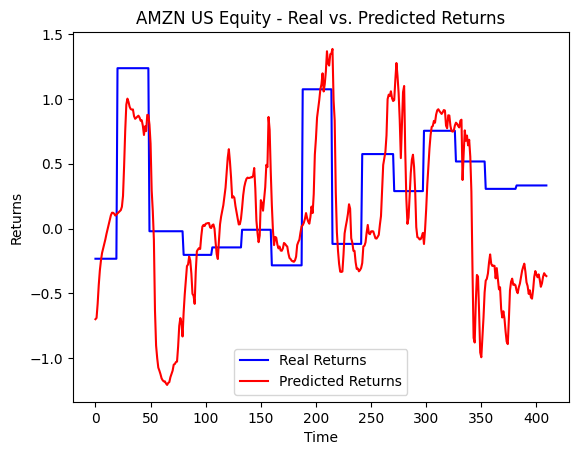

y vs y_pred: (316,) vs (316, 1)


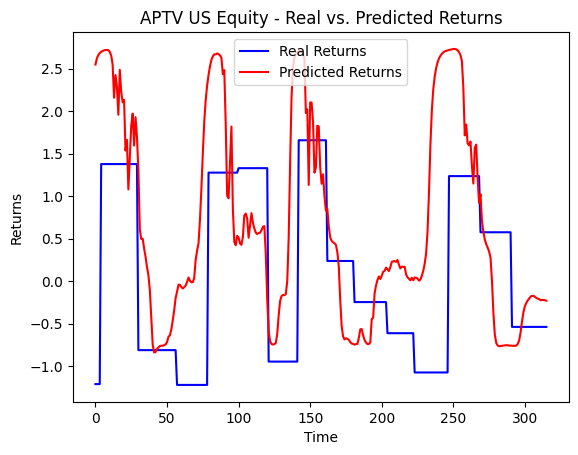

y vs y_pred: (314,) vs (314, 1)


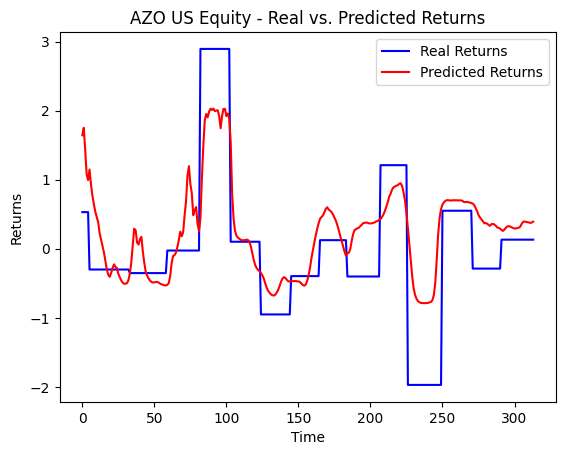

y vs y_pred: (324,) vs (324, 1)


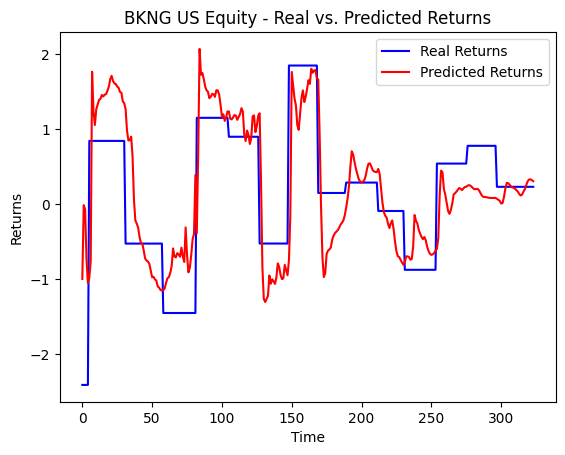

y vs y_pred: (314,) vs (314, 1)


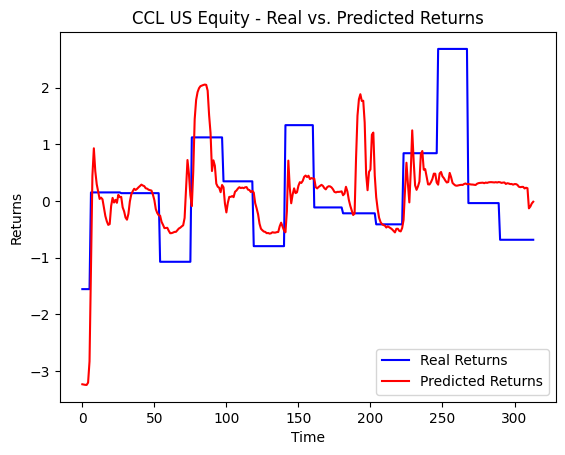

y vs y_pred: (325,) vs (325, 1)


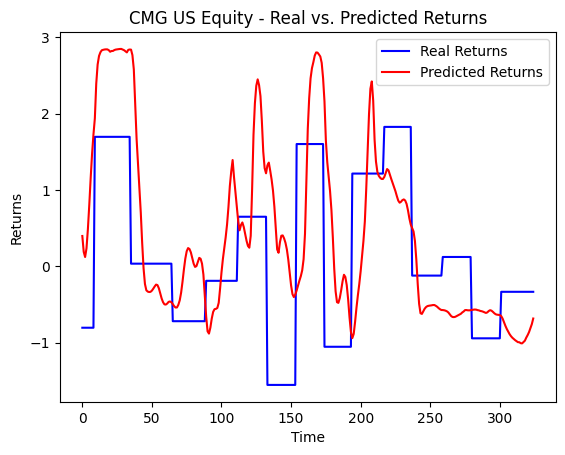

y vs y_pred: (306,) vs (306, 1)


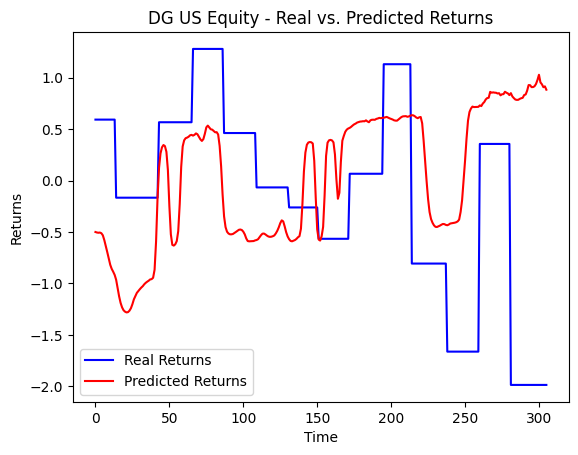

y vs y_pred: (325,) vs (325, 1)


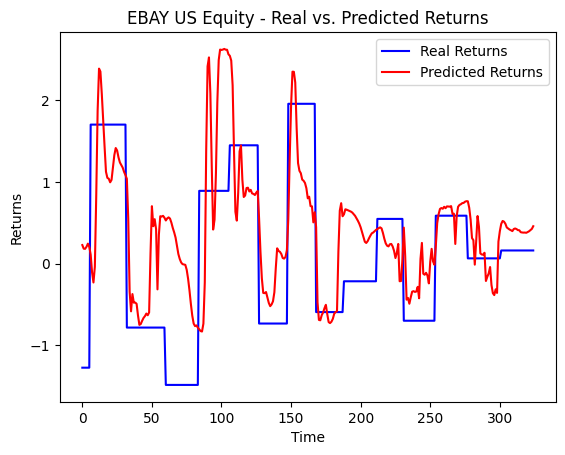

y vs y_pred: (394,) vs (394, 1)


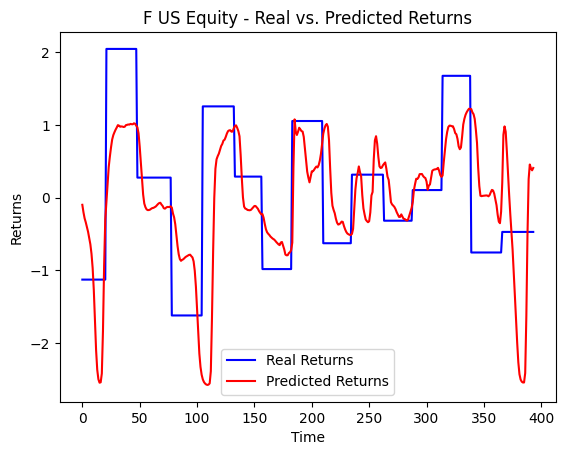

y vs y_pred: (418,) vs (418, 1)


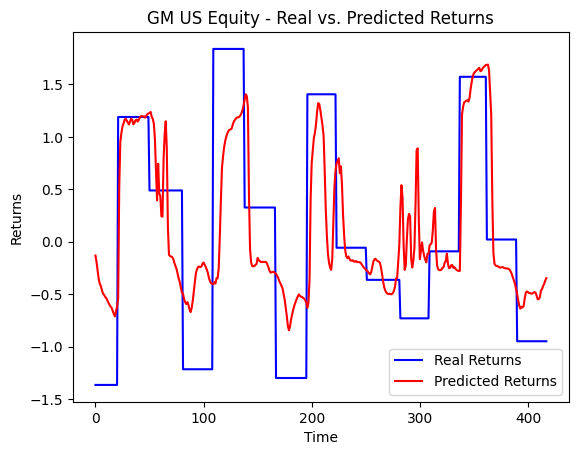

y vs y_pred: (330,) vs (330, 1)


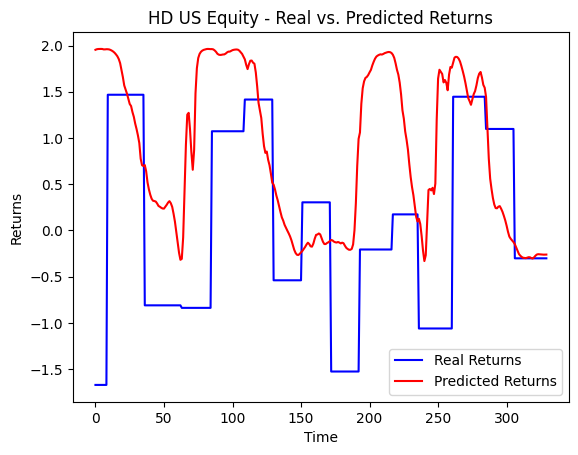

y vs y_pred: (317,) vs (317, 1)


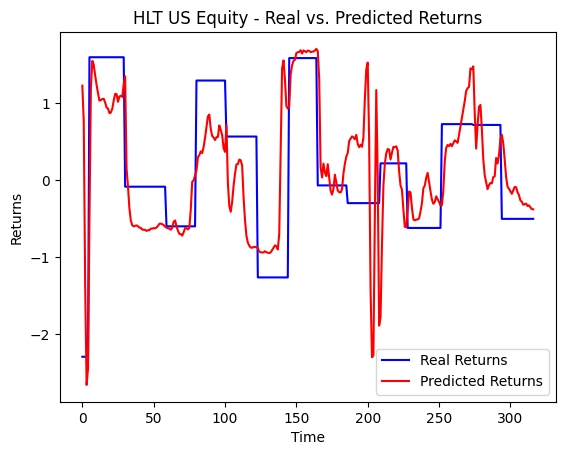

y vs y_pred: (325,) vs (325, 1)


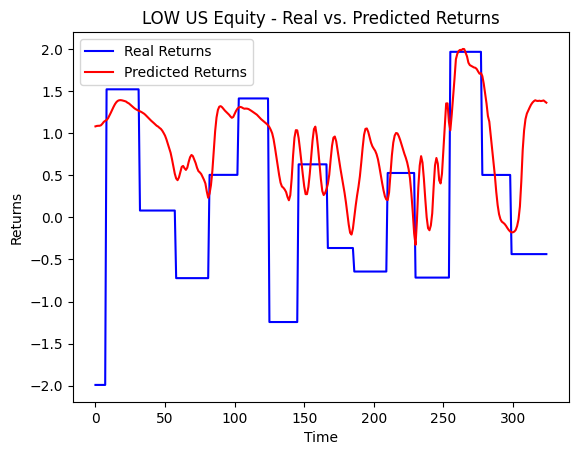

y vs y_pred: (324,) vs (324, 1)


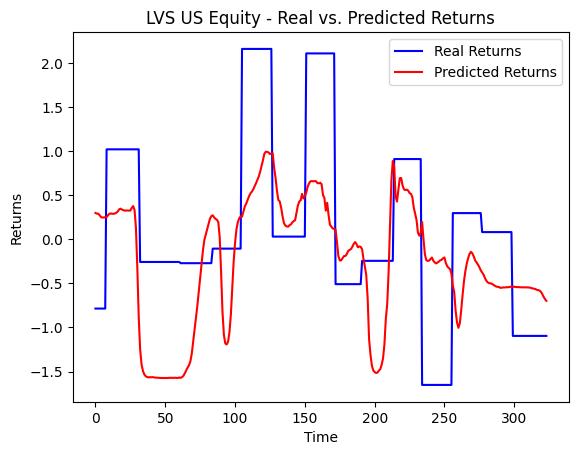

y vs y_pred: (341,) vs (341, 1)


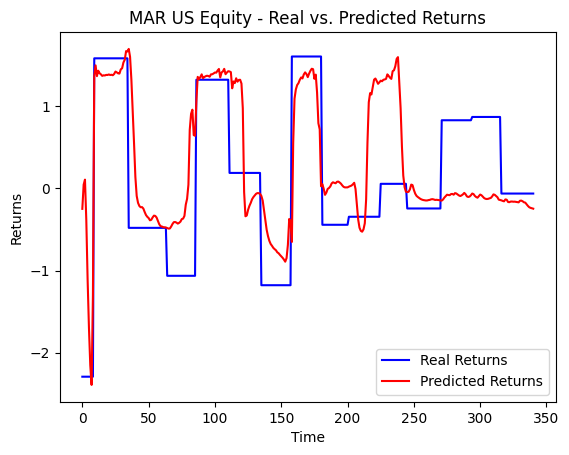

y vs y_pred: (336,) vs (336, 1)


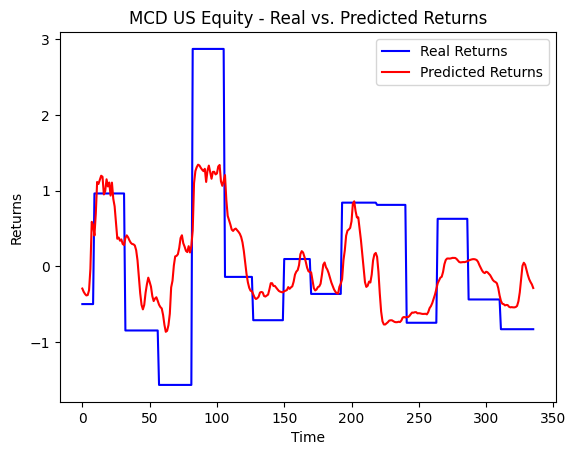

y vs y_pred: (346,) vs (346, 1)


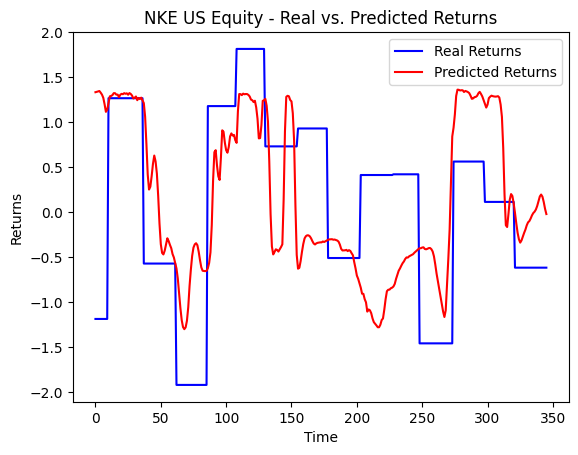

y vs y_pred: (316,) vs (316, 1)


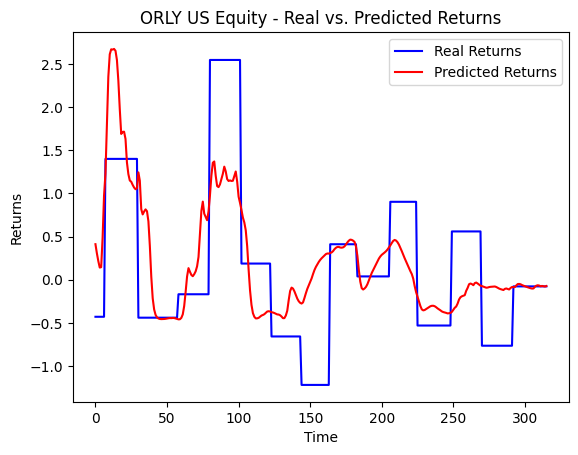

y vs y_pred: (319,) vs (319, 1)


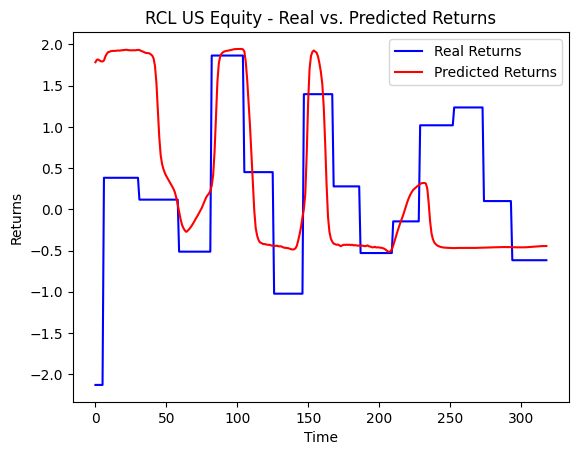

y vs y_pred: (322,) vs (322, 1)


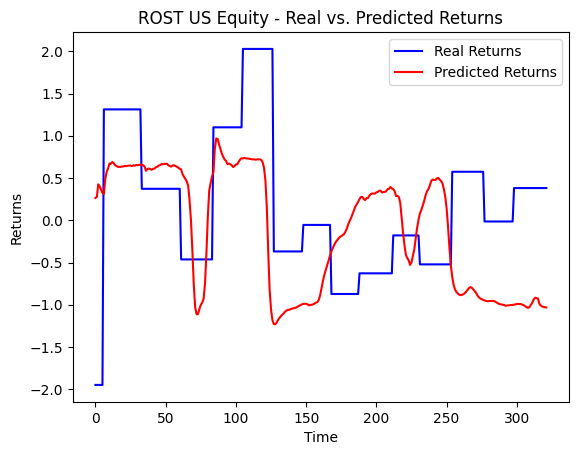

y vs y_pred: (348,) vs (348, 1)


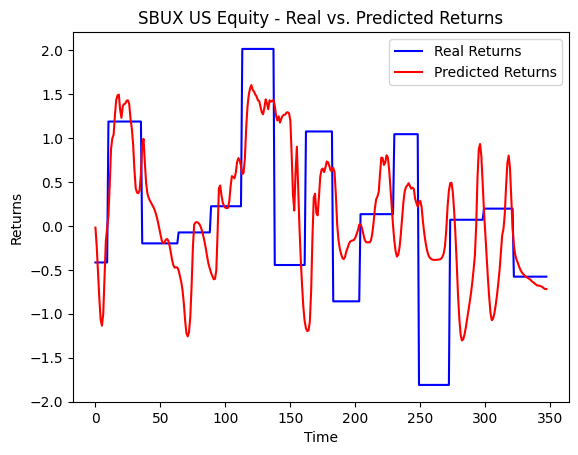

y vs y_pred: (321,) vs (321, 1)


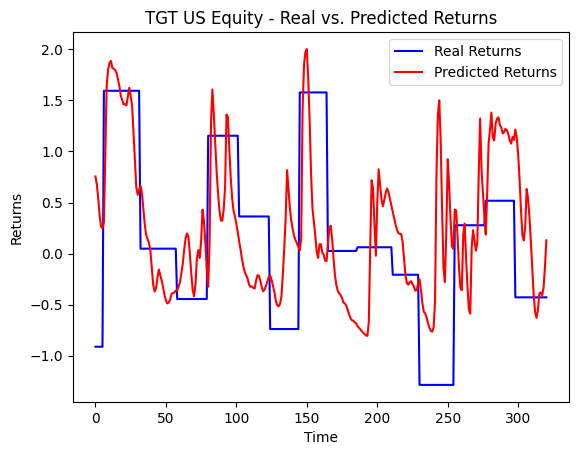

y vs y_pred: (318,) vs (318, 1)


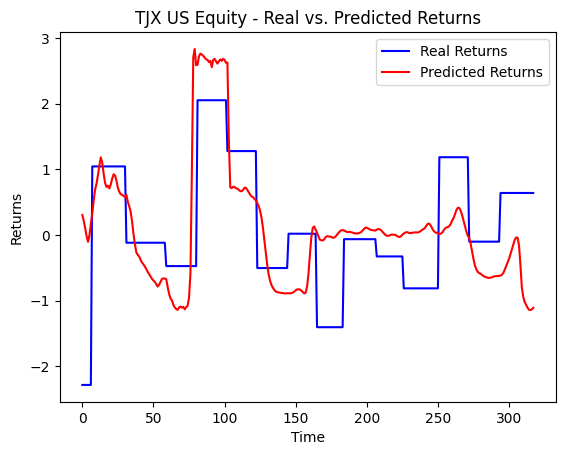

y vs y_pred: (321,) vs (321, 1)


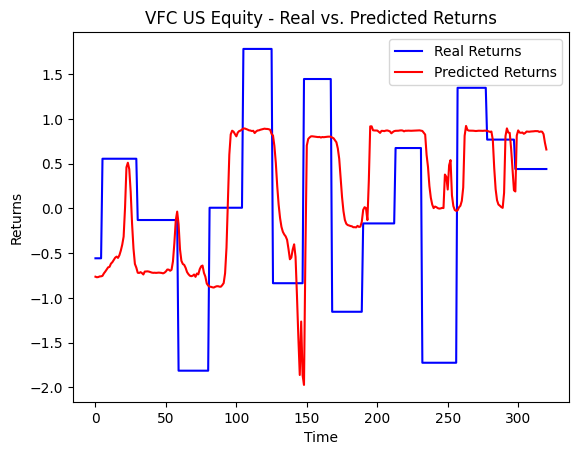

y vs y_pred: (347,) vs (347, 1)


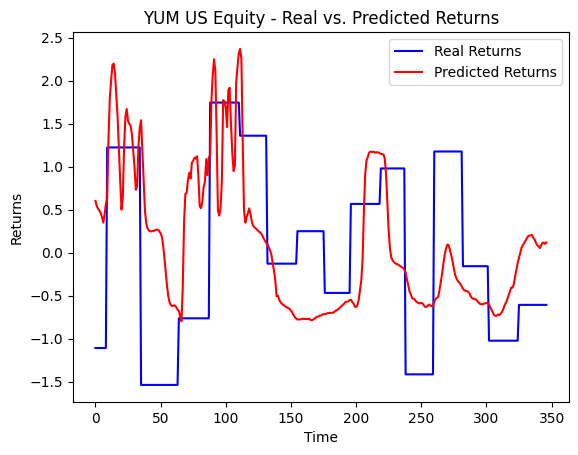

In [ ]:
# Iterate over each stock in the dictionary
for stock_name, predictions in pred25_cur.items():
    y_preds = predictions['y_preds']
    y = predictions['y']

    # Create a figure and axis
    fig, ax = plt.subplots()
    print(f'y vs y_pred: {y.shape} vs {y_preds.shape}')


    # Plot the real returns (y) in blue
    ax.plot(y, label='Real Returns', color='blue')

    # Plot the predicted returns (y_preds) in red
    ax.plot(y_preds, label='Predicted Returns', color='red')

    # Set axis labels and a legend
    ax.set_xlabel('Time')
    ax.set_ylabel('Returns')
    ax.set_title(f'{stock_name} - Real vs. Predicted Returns')
    ax.legend()

    # Display or save the plot as needed
    plt.show()  # Use plt.savefig('filename.png') to save the plot to a file




In [ ]:
pred25_cur = pd.DataFrame(pred25_cur)

In [ ]:
pred25_cur

AMZN US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -0.532028   
rmse                                                         0.575344   
mse                                                          0.331021   
y_preds             [[-0.6980424], [-0.6884271], [-0.57904434], [-...   
y                   [-0.23210444606497796, -0.23210444606497796, -...   

                                                       APTV US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -0.648868   
rmse                                                         1.316391   
mse                                                          1.732886   
y_preds             [[2.5490701], [2.6216443], [2.6611986], [2.683...   
y                   [-1.2126143889412746, -1.2126143889412746, -1....   

                                                        AZO US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.562098   
rmse                                                         0.687556   
mse                                                          0.472734   
y_preds             [[1.6435118], [1.7517955], [1.427488], [1.0773...   
y                   [0.5301004605407691, 0.5301004605407691, 0.530...   

                                                       BKNG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.512822   
rmse                                                         0.627797   
mse                                                          0.394129   
y_preds             [[-0.9932903], [-0.009100646], [-0.06490117], ...   
y                   [-2.4068948928092997, -2.4068948928092997, -2....   

                                                        CCL US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.126612   
rmse                                                         0.904771   
mse                                                          0.818611   
y_preds             [[-3.237199], [-3.2431624], [-3.2473326], [-3....   
y                   [-1.5566849508933416, -1.5566849508933416, -1....   

                                                        CMG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -0.071249   
rmse                                                          1.06462   
mse                                                          1.133415   
y_preds             [[0.39659497], [0.18906787], [0.12092078], [0....   
y                   [-0.8058582084981689, -0.8058582084981689, -0....   

                                                         DG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -0.668849   
rmse                                                         1.184688   
mse                                                          1.403485   
y_preds             [[-0.49952194], [-0.50448775], [-0.50688225], ...   
y                   [0.59312530498382, 0.59312530498382, 0.5931253...   

                                                       EBAY US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.315407   
rmse                                                         0.835541   
mse                                                          0.698129   
y_preds             [[0.22800216], [0.1836425], [0.18147261], [0.2...   
y                   [-1.274460030

## Aggregate model

In [ ]:
pred25_aggregate_cur = train_aggregate_model(train_df = stock_ONE_cur, val_df = stock25_cur, task = 'current', N_epoch = 30)

Epoch 1/30
375/375 [==============================] - ETA: 0s - loss: 0.3570
Epoch 1: val_loss improved from inf to 0.11533, saving model to weights_task_current_aggregate_model.h5
375/375 [==============================] - 110s 268ms/step - loss: 0.3570 - val_loss: 0.1153 - lr: 0.0100
Epoch 2/30
375/375 [==============================] - ETA: 0s - loss: 0.2174
Epoch 2: val_loss did not improve from 0.11533
375/375 [==============================] - 103s 274ms/step - loss: 0.2174 - val_loss: 0.1323 - lr: 0.0100
Epoch 3/30
375/375 [==============================] - ETA: 0s - loss: 0.2048
Epoch 3: val_loss improved from 0.11533 to 0.09272, saving model to weights_task_current_aggregate_model.h5
375/375 [==============================] - 103s 275ms/step - loss: 0.2048 - val_loss: 0.0927 - lr: 0.0100
Epoch 4/30
375/375 [==============================] - ETA: 0s - loss: 0.1847
Epoch 4: val_loss improved from 0.09272 to 0.07882, saving model to weights_task_current_aggregate_model.h5
375/375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




-------------------AMZN US Equity--------------------
13/13 [==============================] - 3s 74ms/step


-------------------APTV US Equity--------------------
10/10 [==============================] - 1s 92ms/step


-------------------AZO US Equity--------------------
10/10 [==============================] - 1s 97ms/step


-------------------BKNG US Equity--------------------
11/11 [==============================] - 1s 90ms/step


-------------------CCL US Equity--------------------
10/10 [==============================] - 1s 104ms/step


-------------------CMG US Equity--------------------
11/11 [==============================] - 1s 69ms/step


-------------------DG US Equity--------------------
10/10 [==============================] - 1s 74ms/step


-------------------EBAY US Equity--------------------
11/11 [==============================] - 1s 69ms/step


-------------------F US Equity--------------------
13/13 [==============================] - 1s 70ms/step


---------------

y vs y_pred: (410,) vs (410, 1)


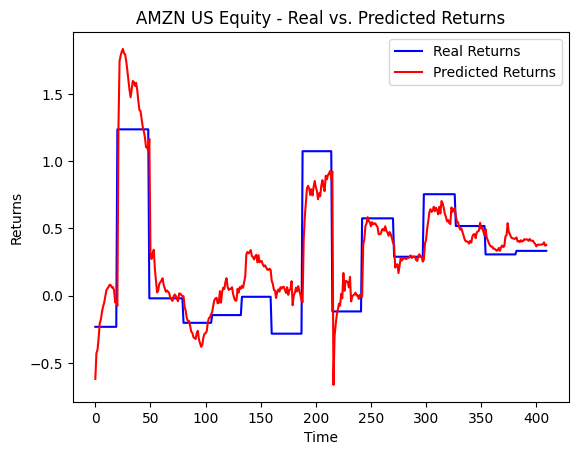

y vs y_pred: (316,) vs (316, 1)


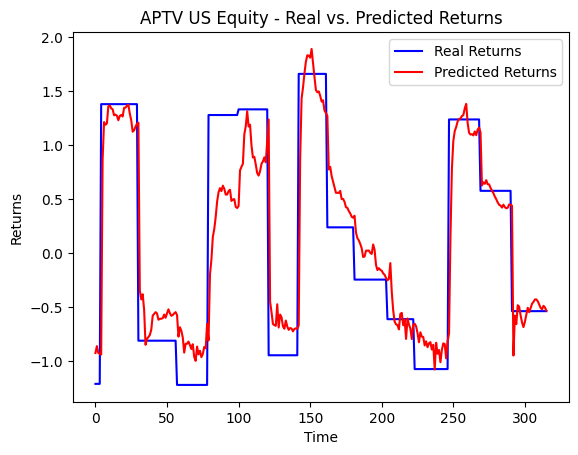

y vs y_pred: (314,) vs (314, 1)


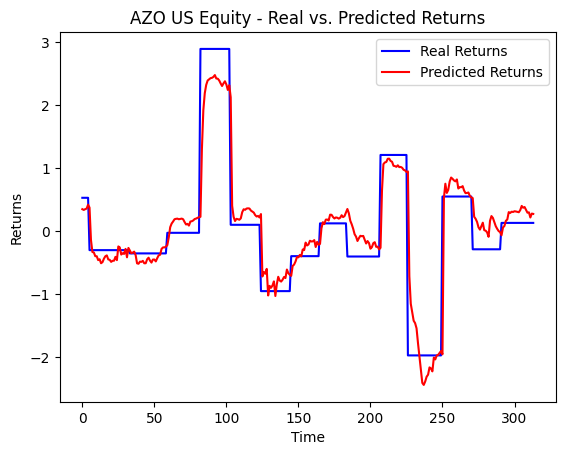

y vs y_pred: (324,) vs (324, 1)


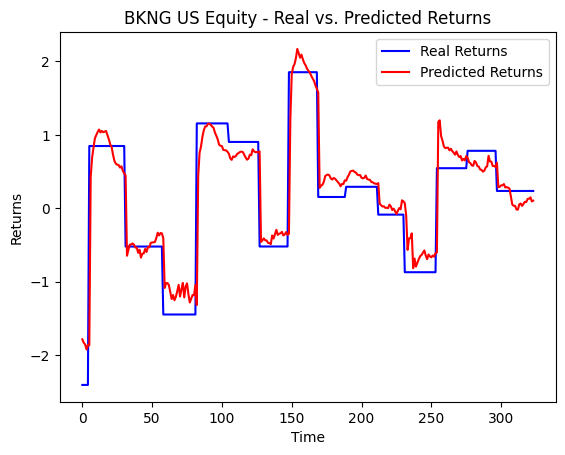

y vs y_pred: (314,) vs (314, 1)


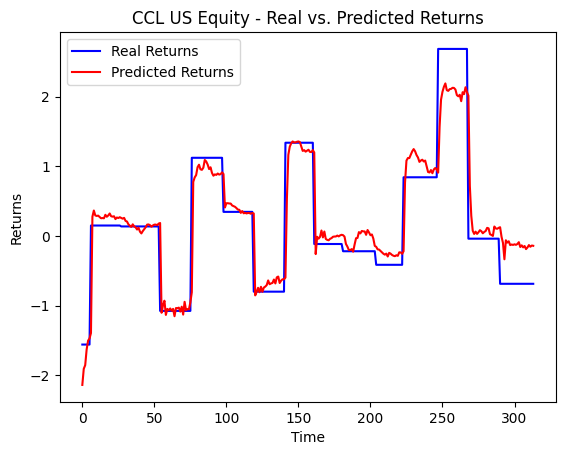

y vs y_pred: (325,) vs (325, 1)


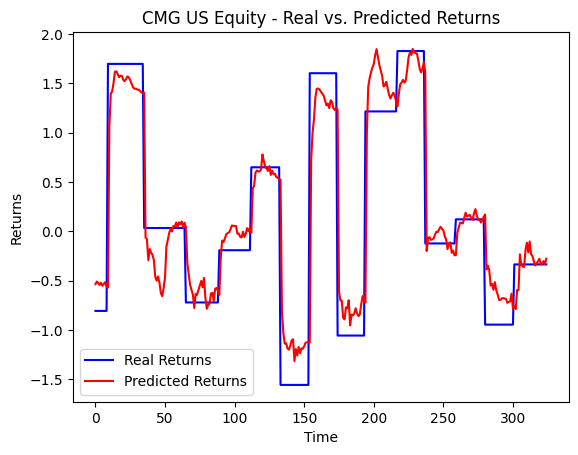

y vs y_pred: (306,) vs (306, 1)


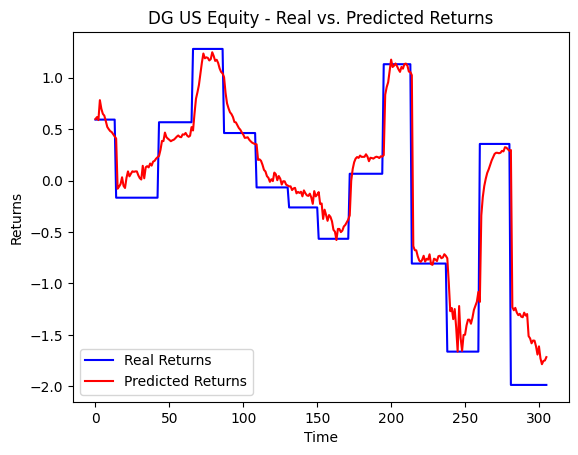

y vs y_pred: (325,) vs (325, 1)


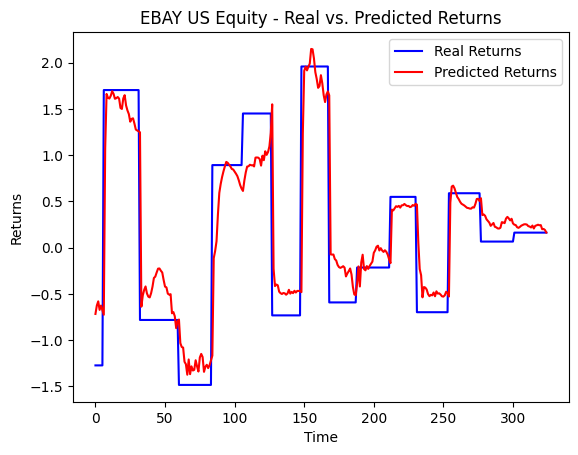

y vs y_pred: (394,) vs (394, 1)


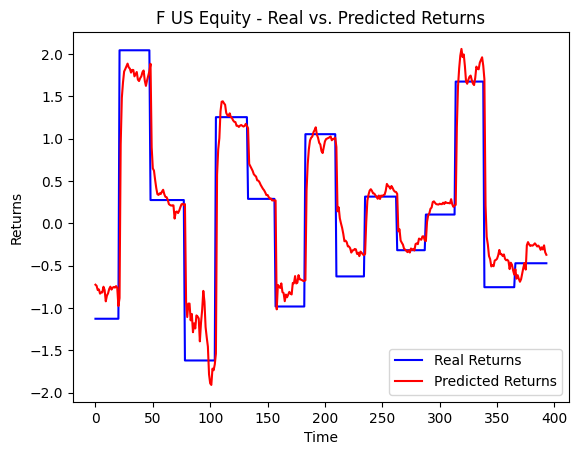

y vs y_pred: (418,) vs (418, 1)


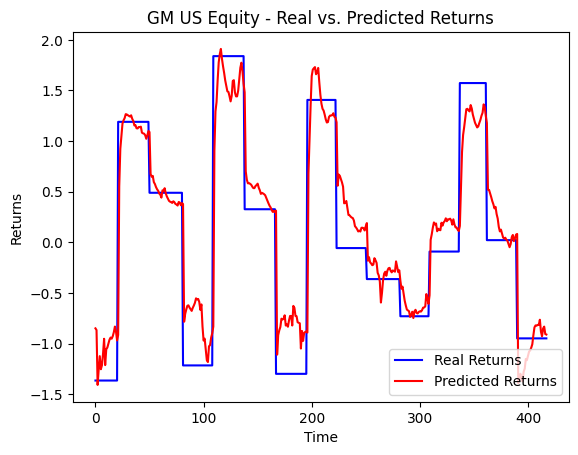

y vs y_pred: (330,) vs (330, 1)


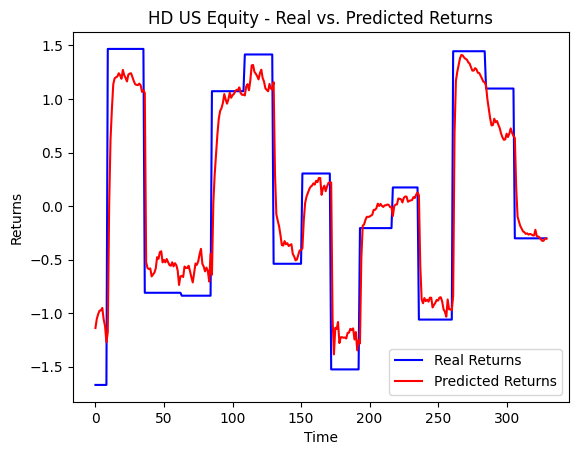

y vs y_pred: (317,) vs (317, 1)


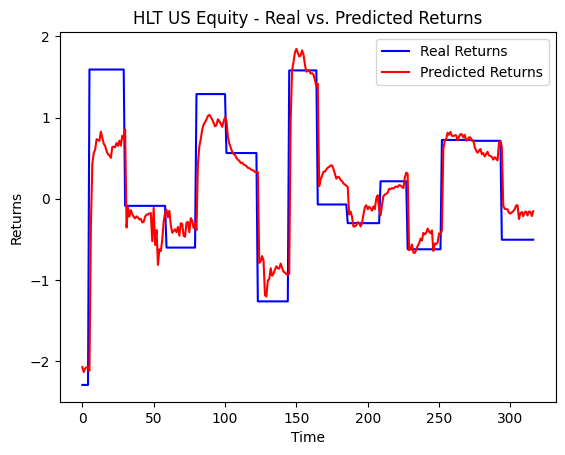

y vs y_pred: (325,) vs (325, 1)


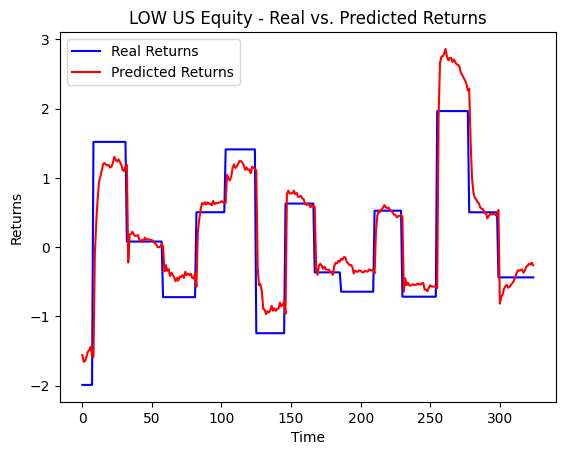

y vs y_pred: (324,) vs (324, 1)


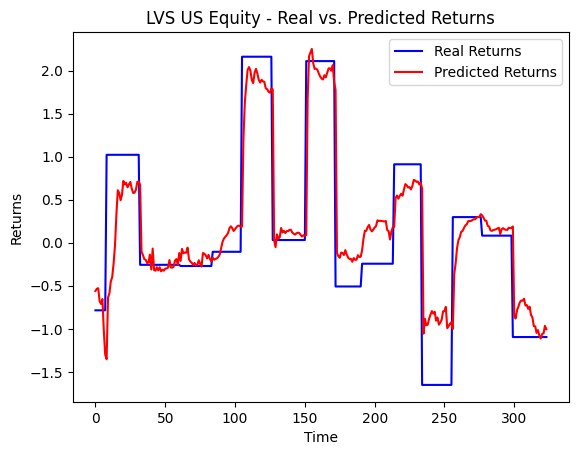

y vs y_pred: (341,) vs (341, 1)


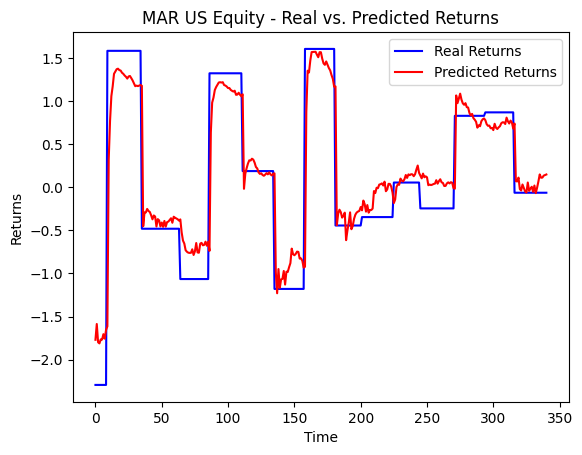

y vs y_pred: (336,) vs (336, 1)


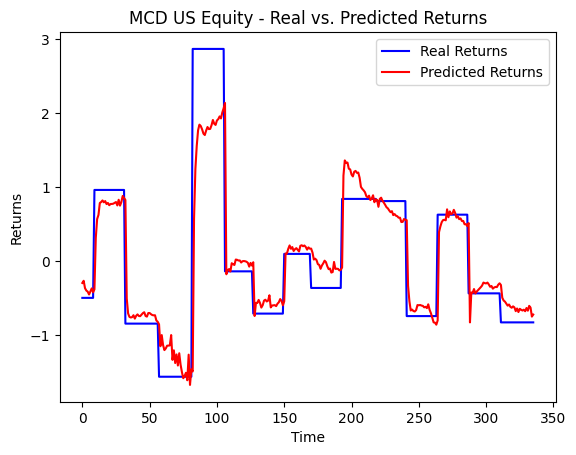

y vs y_pred: (346,) vs (346, 1)


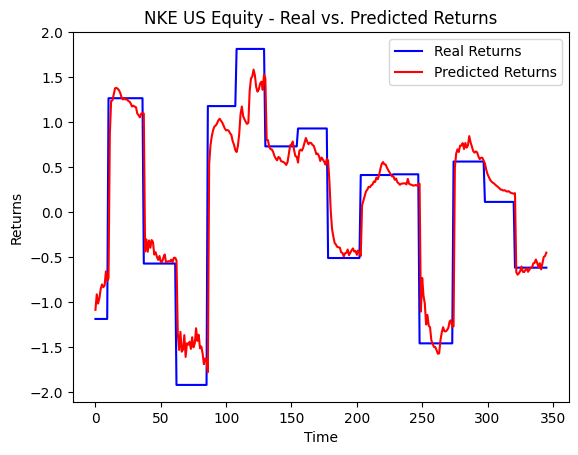

y vs y_pred: (316,) vs (316, 1)


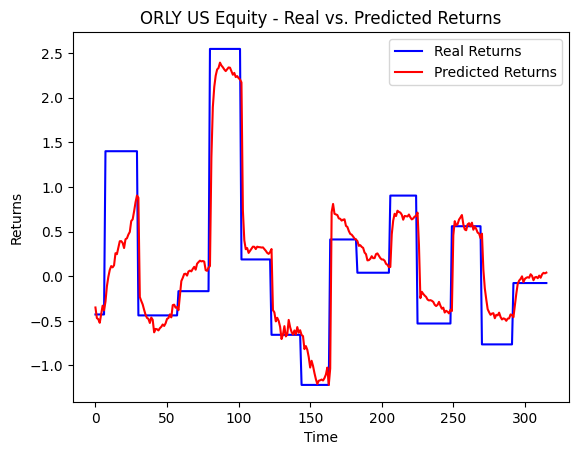

y vs y_pred: (319,) vs (319, 1)


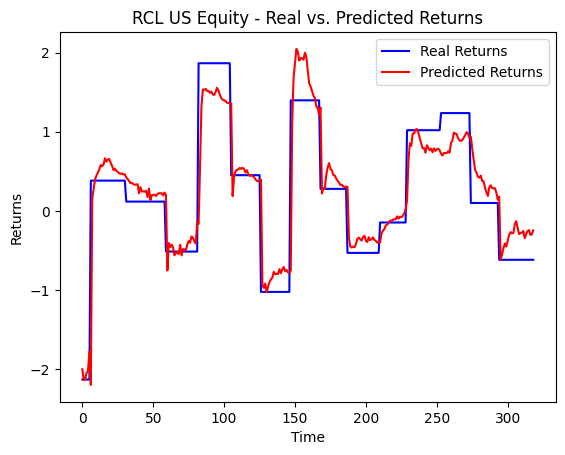

y vs y_pred: (322,) vs (322, 1)


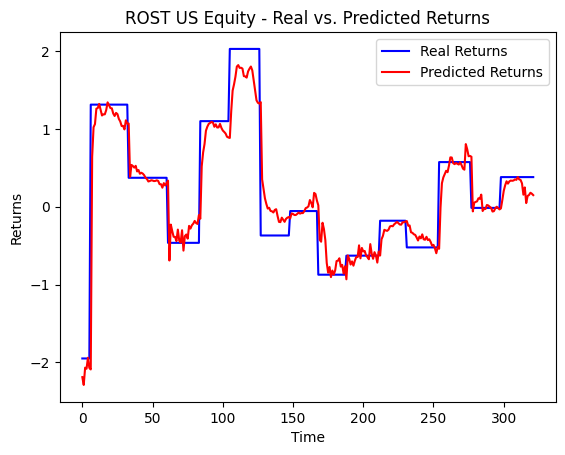

y vs y_pred: (348,) vs (348, 1)


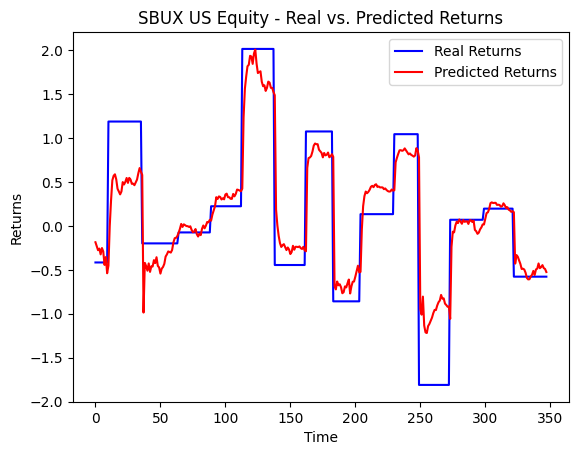

y vs y_pred: (321,) vs (321, 1)


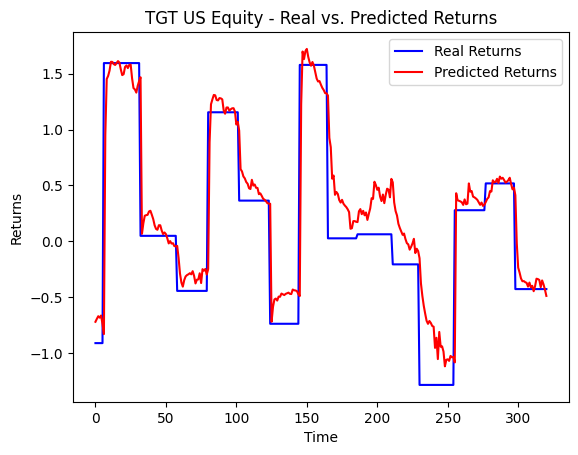

y vs y_pred: (318,) vs (318, 1)


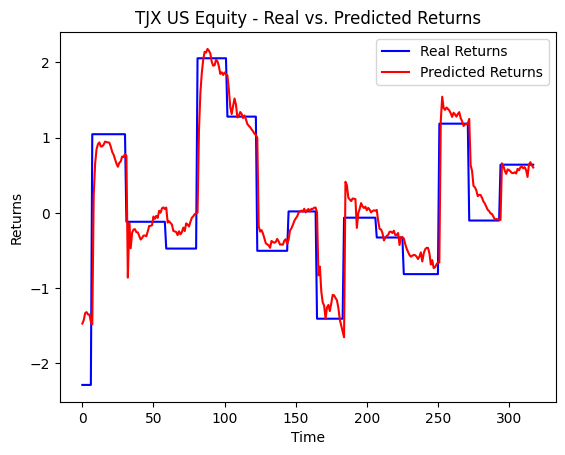

y vs y_pred: (321,) vs (321, 1)


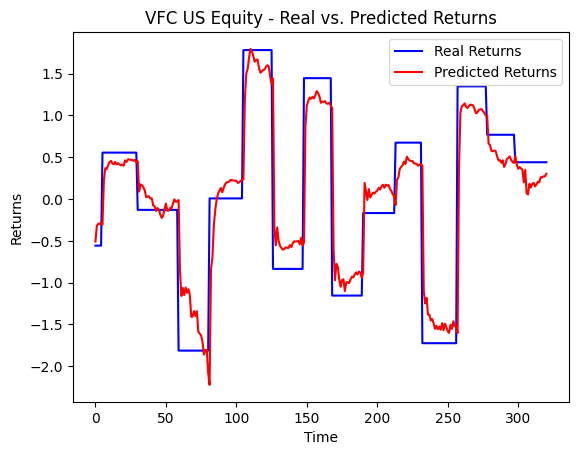

y vs y_pred: (347,) vs (347, 1)


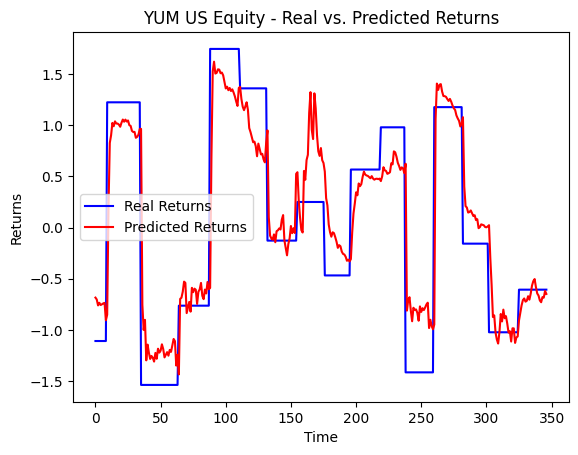

AMZN US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                            0.75289   
rmse                                                         0.231068   
mse                                                          0.053392   
y_preds             [[-0.6197474], [-0.4294466], [-0.40200356], [-...   
y                   [-0.23210444606497796, -0.23210444606497796, -...   

                                                       APTV US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.796041   
rmse                                                         0.462982   
mse                                                          0.214352   
y_preds             [[-0.92708474], [-0.862912], [-0.9271443], [-0...   
y                   [-1.2126143889412746, -1.2126143889412746, -1....   

                                                        AZO US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.835039   
rmse                                                         0.421998   
mse                                                          0.178082   
y_preds             [[0.3496062], [0.3376143], [0.34964284], [0.35...   
y                   [0.5301004605407691, 0.5301004605407691, 0.530...   

                                                       BKNG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.836597   
rmse                                                         0.363584   
mse                                                          0.132194   
y_preds             [[-1.7854238], [-1.8318242], [-1.8546693], [-1...   
y                   [-2.4068948928092997, -2.4068948928092997, -2....   

                                                        CCL US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.841589   
rmse                                                         0.385326   
mse                                                          0.148476   
y_preds             [[-2.1361086], [-1.9049814], [-1.8527018], [-1...   
y                   [-1.5566849508933416, -1.5566849508933416, -1....   

                                                        CMG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                            0.83985   
rmse                                                         0.411636   
mse                                                          0.169444   
y_preds             [[-0.53484184], [-0.5084044], [-0.5230007], [-...   
y                   [-0.8058582084981689, -0.8058582084981689, -0....   

                                                         DG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.875261   
rmse                                                         0.323889   
mse                                                          0.104904   
y_preds             [[0.5985608], [0.61719364], [0.5884953], [0.78...   
y                   [0.59312530498382, 0.59312530498382, 0.5931253...   

                                                       EBAY US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.813992   
rmse                                                         0.435529   
mse                                                          0.189686   
y_preds             [[-0.7178732], [-0.62678134], [-0.58173394], [...   
y                   [-1.274460030

In [ ]:
# Iterate over each stock in the dictionary
for stock_name, predictions in pred25_aggregate_cur.items():
    y_preds = predictions['y_preds']
    y = predictions['y']

    # Create a figure and axis
    fig, ax = plt.subplots()
    print(f'y vs y_pred: {y.shape} vs {y_preds.shape}')


    # Plot the real returns (y) in blue
    ax.plot(y, label='Real Returns', color='blue')

    # Plot the predicted returns (y_preds) in red
    ax.plot(y_preds, label='Predicted Returns', color='red')

    # Set axis labels and a legend
    ax.set_xlabel('Time')
    ax.set_ylabel('Returns')
    ax.set_title(f'{stock_name} - Real vs. Predicted Returns')
    ax.legend()

    # Display or save the plot as needed
    plt.show()  # Use plt.savefig('filename.png') to save the plot to a file


pred25_aggregate_cur = pd.DataFrame(pred25_aggregate_cur)
pred25_aggregate_cur

* questoins:
* I have very little training samples for each stock and each model?
* how to improve the performance? really bad (negative R_square)

In [ ]:
analysis_path = f'/content/gdrive/MyDrive/lazard/models/task_current/outputs/LSTM_current_lr0.01_nocomp.csv'
pred25_cur.to_csv(analysis_path)

In [ ]:
analysis_path = f'/content/gdrive/MyDrive/lazard/models/task_current/outputs/aggregateLSTM_current_lr0.01_nocomp.csv'
pred25_aggregate_cur.to_csv(analysis_path)